# Finite window correction

Demos of our statistical correction made for [(Beltran et. al.,
*in preparation*)](
https://www.overleaf.com/project/5c6c76d88d00f95294959995).

In [1]:
import warnings
from matplotlib._api import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

In [2]:
import matplotlib as mpl
import numpy as np

import multi_locus_analysis as mla
import multi_locus_analysis.finite_window as fw
import multi_locus_analysis.plotting.finite_window as fplt
import bruno_util.plotting as bplt

figure_size = bplt.use_cell_style(mpl.rcParams)

## Variables

Prepackage the different example variables we will use.

In [3]:
from multi_locus_analysis.plotting import Variable
from scipy.stats import beta, expon
import seaborn as sns

variable_pairs = {}
windows = {}

# for Beta distributions, making the window size a little less than 1 guarantees there's not too many,
# and also not too fewobs per trajectory, so that the effect we want to show is visible
windows['beta'] = 0.8
variable_pairs['beta'] = [
    Variable(beta(5, 2), 
             name='Beta(5, 2)',
             pretty_name=r'Beta$(\alpha{}=5, \beta{}=2)$', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[2],
             scaled_ylim=4.0),
    Variable(beta(2, 2),
             name='Beta(2, 2)',
             pretty_name=r'Beta$(\alpha{}=2, \beta{}=2)$', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[3],
             scaled_ylim=2.0)
]


windows['exp'] = 2 + 4 + 2
variable_pairs['exp'] = [
    Variable(expon(scale=4), 
             name=f'Exp(4)', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[4],
             scaled_ylim=0.3),
    Variable(expon(loc=2, scale=2), 
             name=f'Exp(2) + 2', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[5],
             scaled_ylim=0.5)
]

Run simulations for each variable pair

In [4]:
%%time
simulations = {}
for name, vars_pair in variable_pairs.items():
    print(f'Simulating: {name}-based Markov renewal process!')
    simulations[name] = fw.ab_window(
        [var.rvs for var in vars_pair],
#         means=[var.mean() for var in vars_pair],
        offset=-100*np.sum([var.mean() for var in vars_pair]),
        window_size=windows[name], 
        num_replicates=100_000,  
        states=[var.name for var in vars_pair]
    )
print('Done!')

Simulating: beta-based Markov renewal process!
Simulating: exp-based Markov renewal process!
Done!
CPU times: user 35.2 s, sys: 899 ms, total: 36.1 s
Wall time: 36.2 s


From each trajectory, we can extract the wait times.

In [5]:
observations = {name: fw.sim_to_obs(sim) for name, sim in simulations.items()}

## Naive histograms and Meier Kaplan

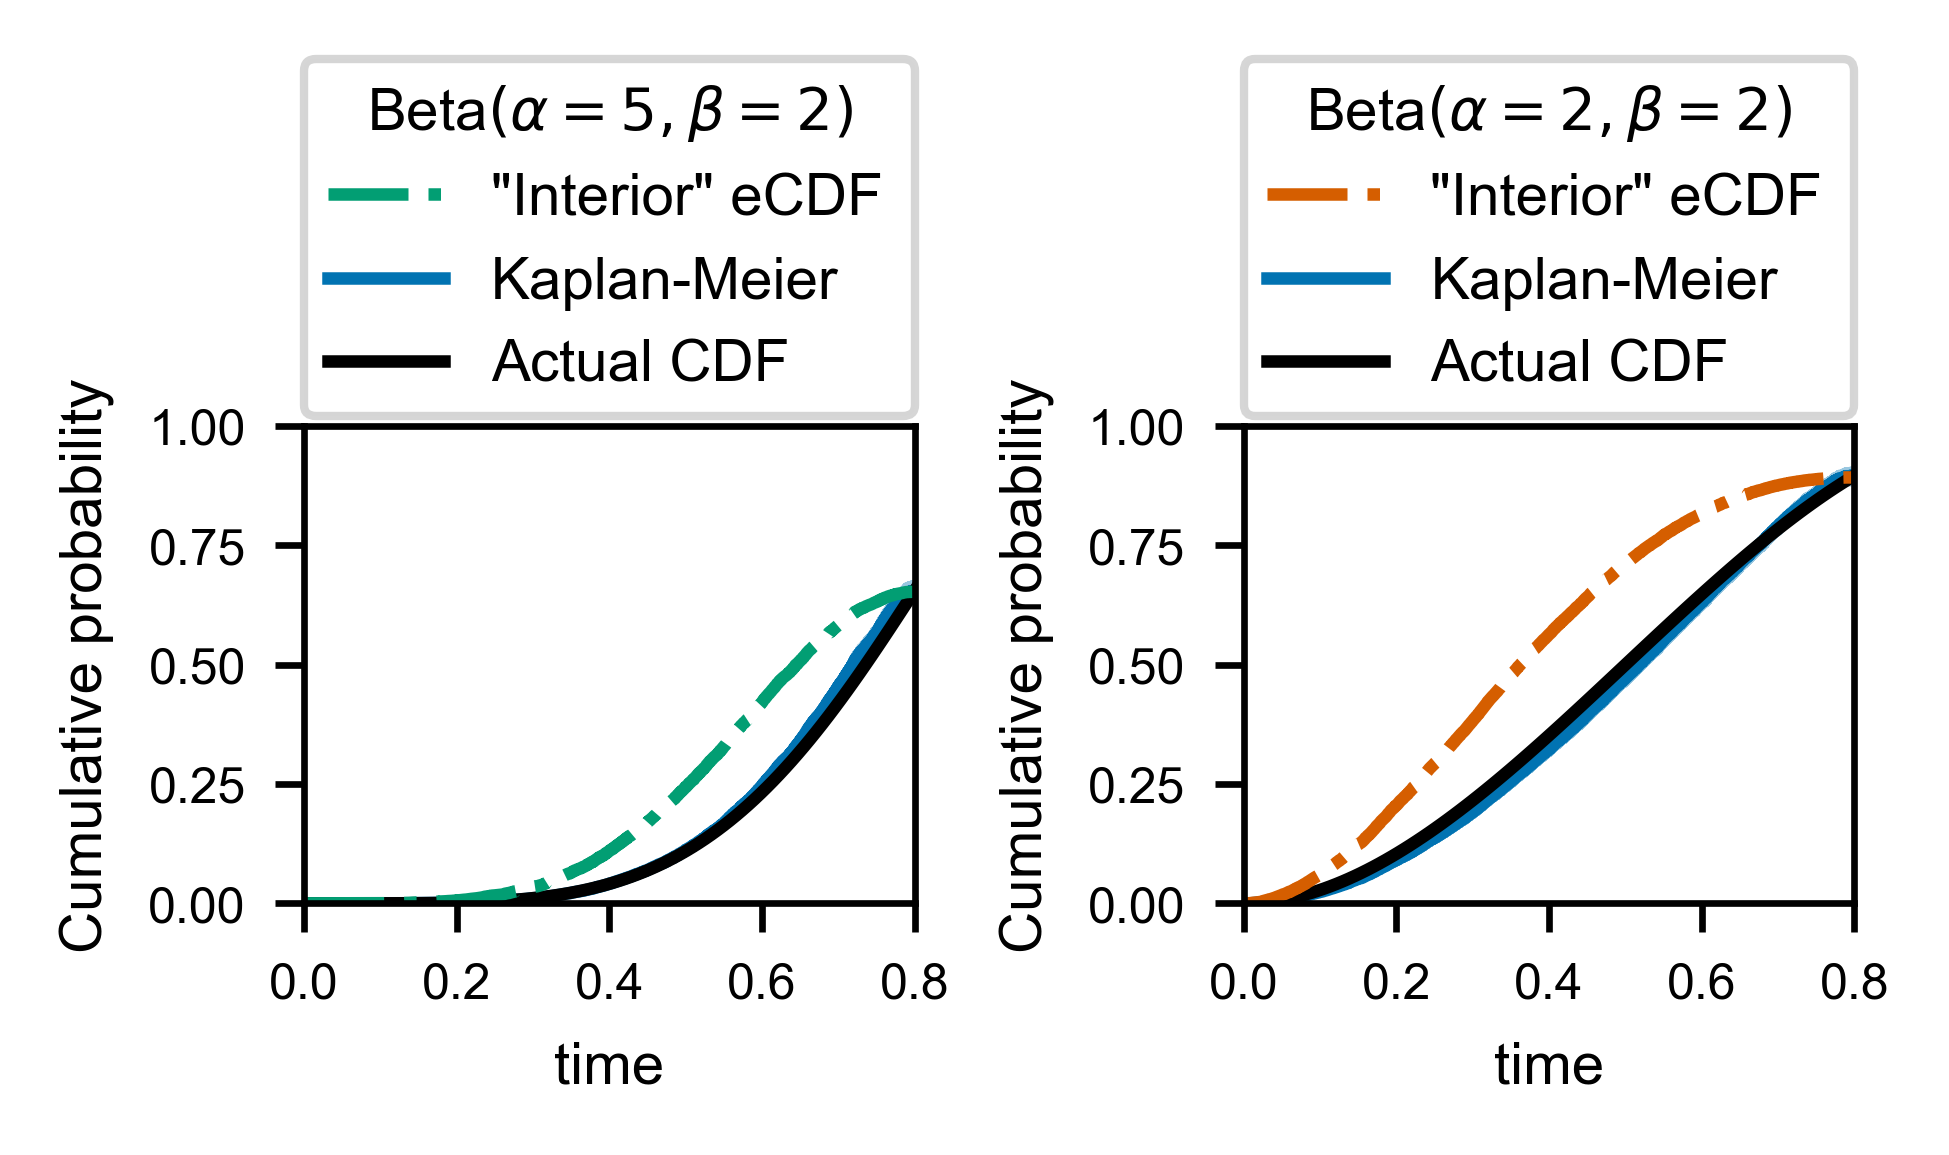

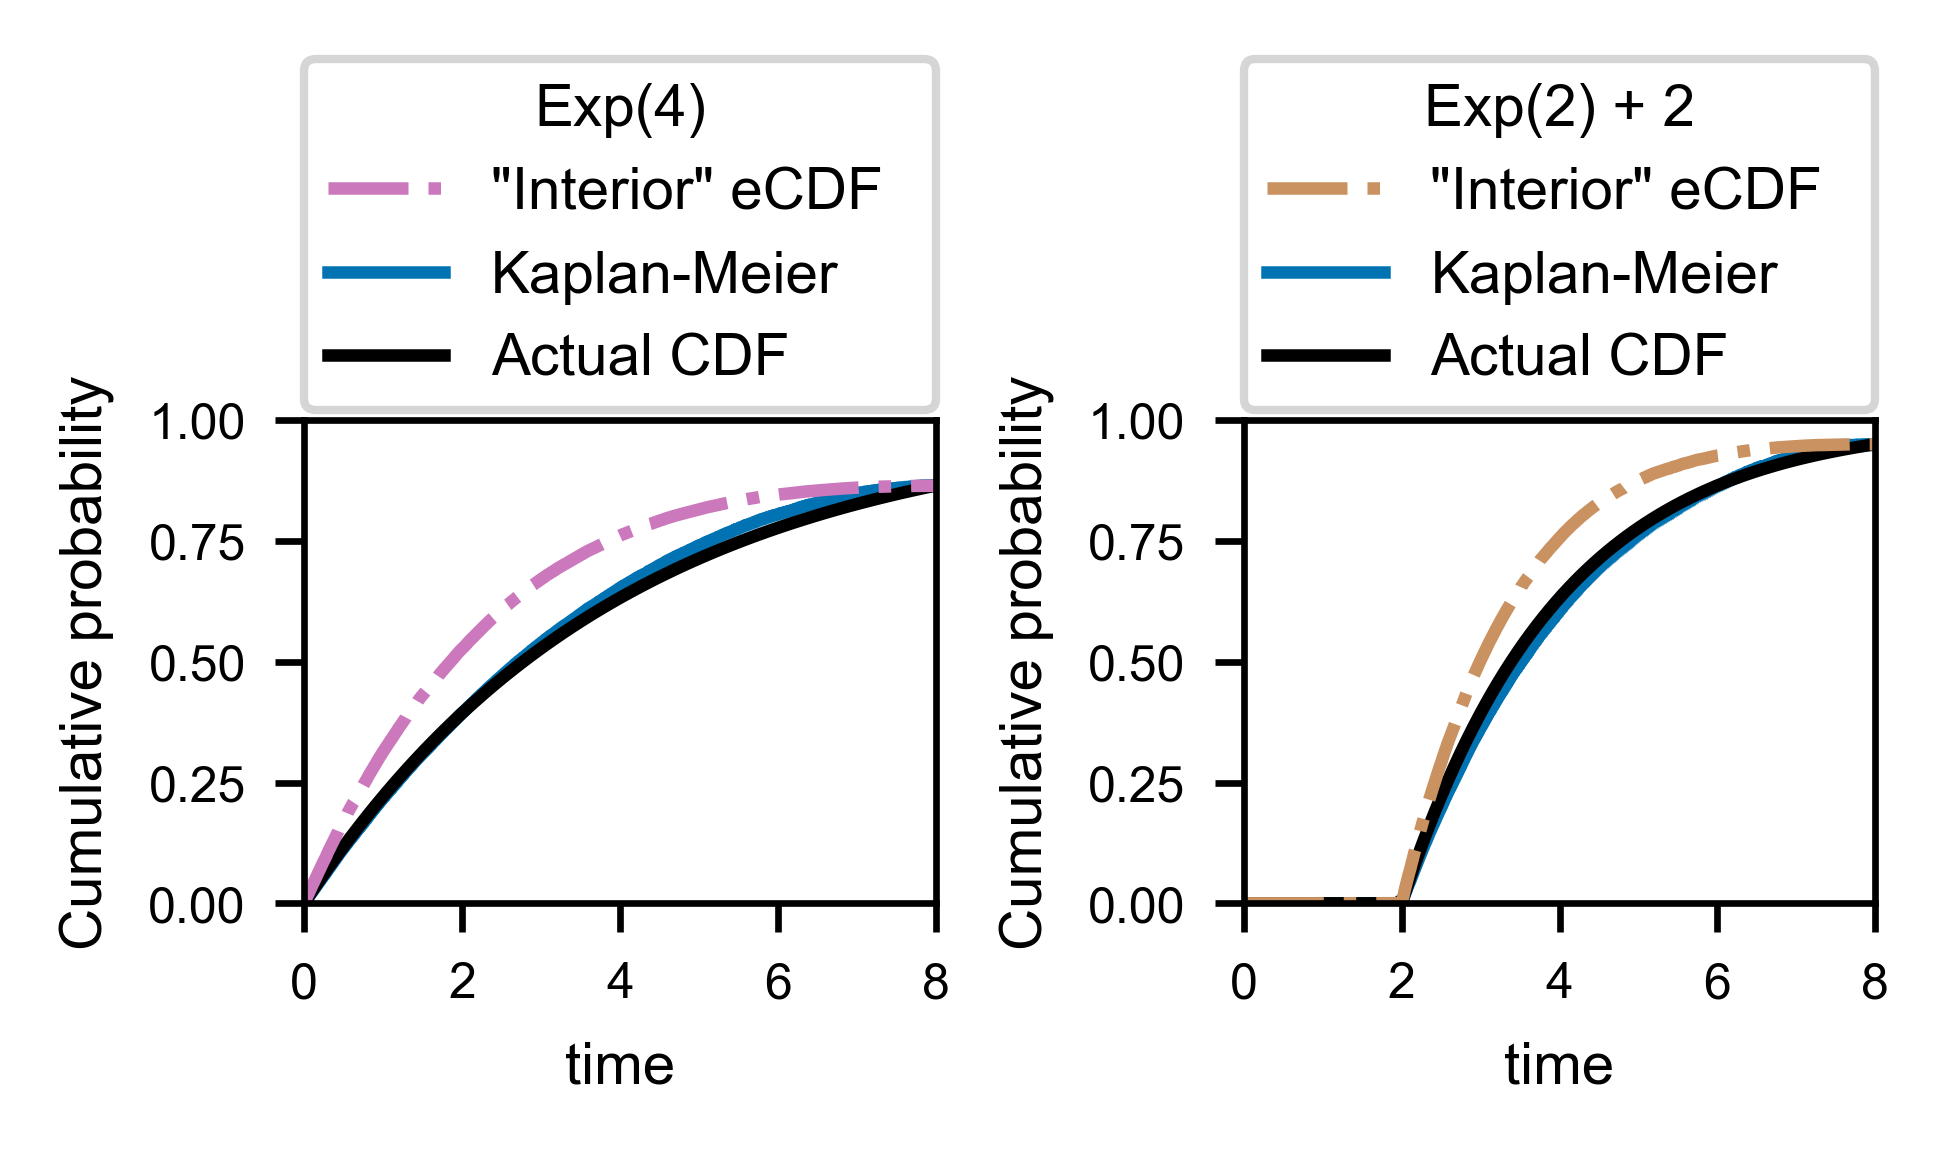

In [6]:
for pair_name, obs in observations.items():
    fplt.compare_interior_kaplan(obs, variable_pairs[pair_name], rescale_kaplan=True, rescale_interior=True)

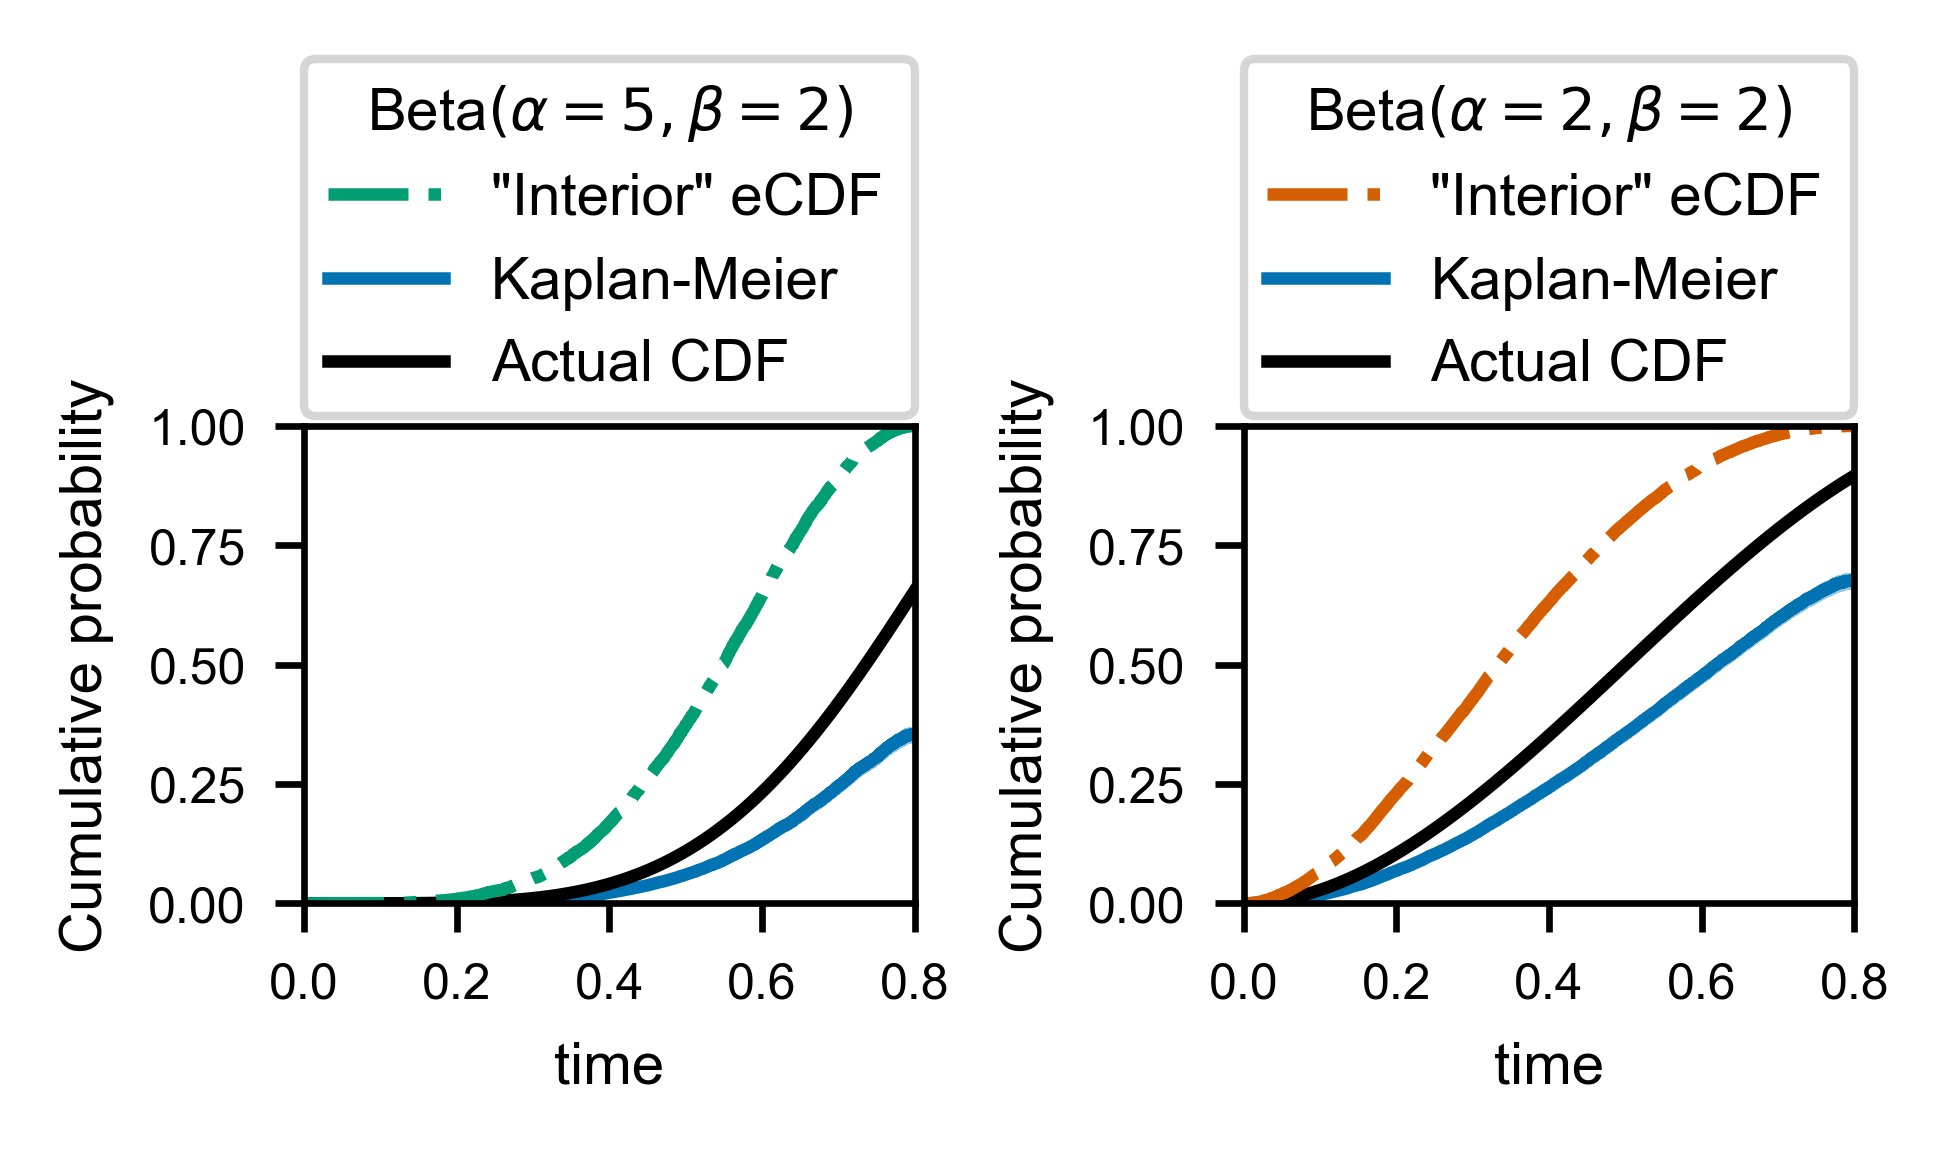

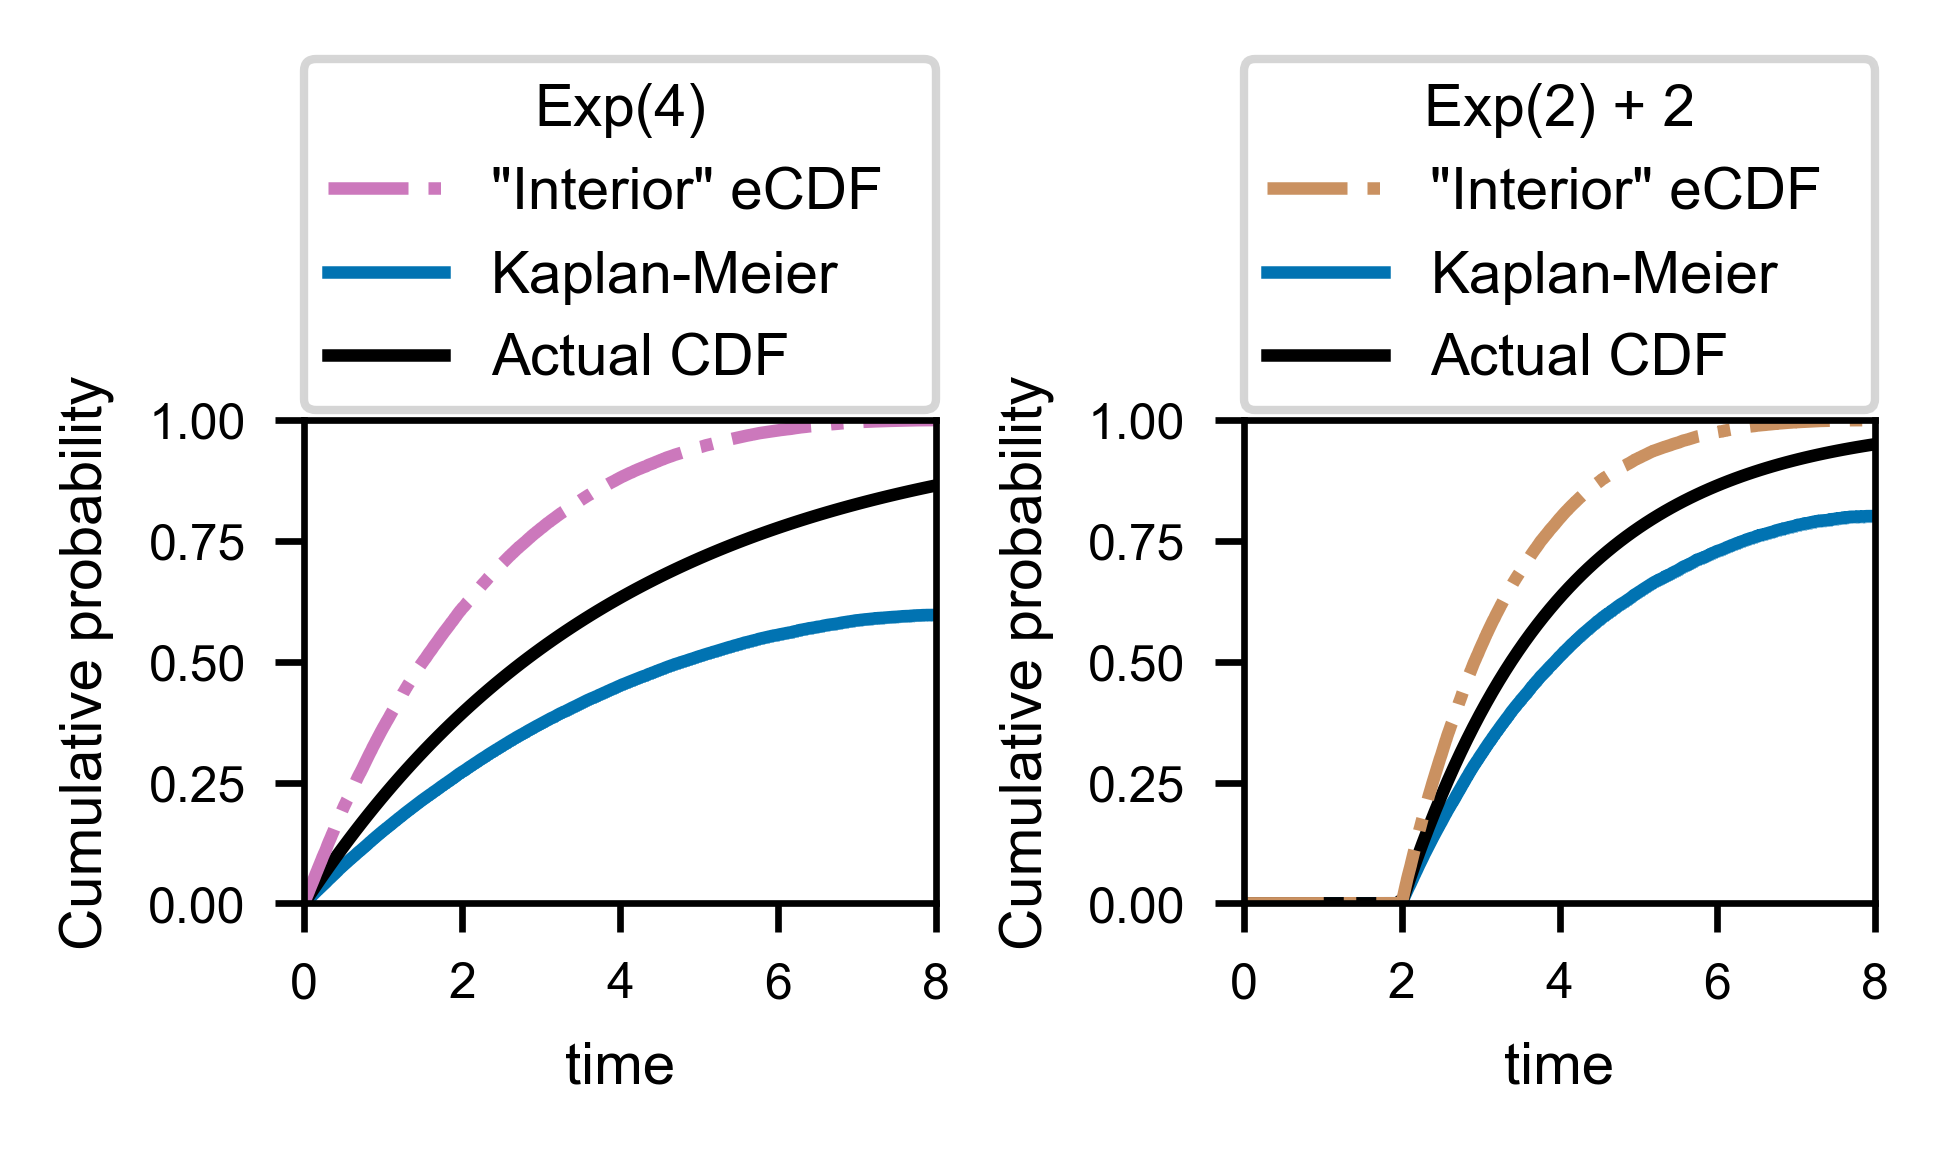

In [7]:
for pair_name, obs in observations.items():
    fplt.compare_interior_kaplan(obs, variable_pairs[pair_name])

## Exterior Times to Survival function

In order to correctly reproduce the actual underlying distribution, we must instead explicitly handle the "exterior censored" and "interior censored" times specially.

The exterior times are easy, as it can be shown (see "Theoretical Details" section below) that the probability distribution of the exterior times is exactly the survival function of the true waiting time distributions, normalized to one:

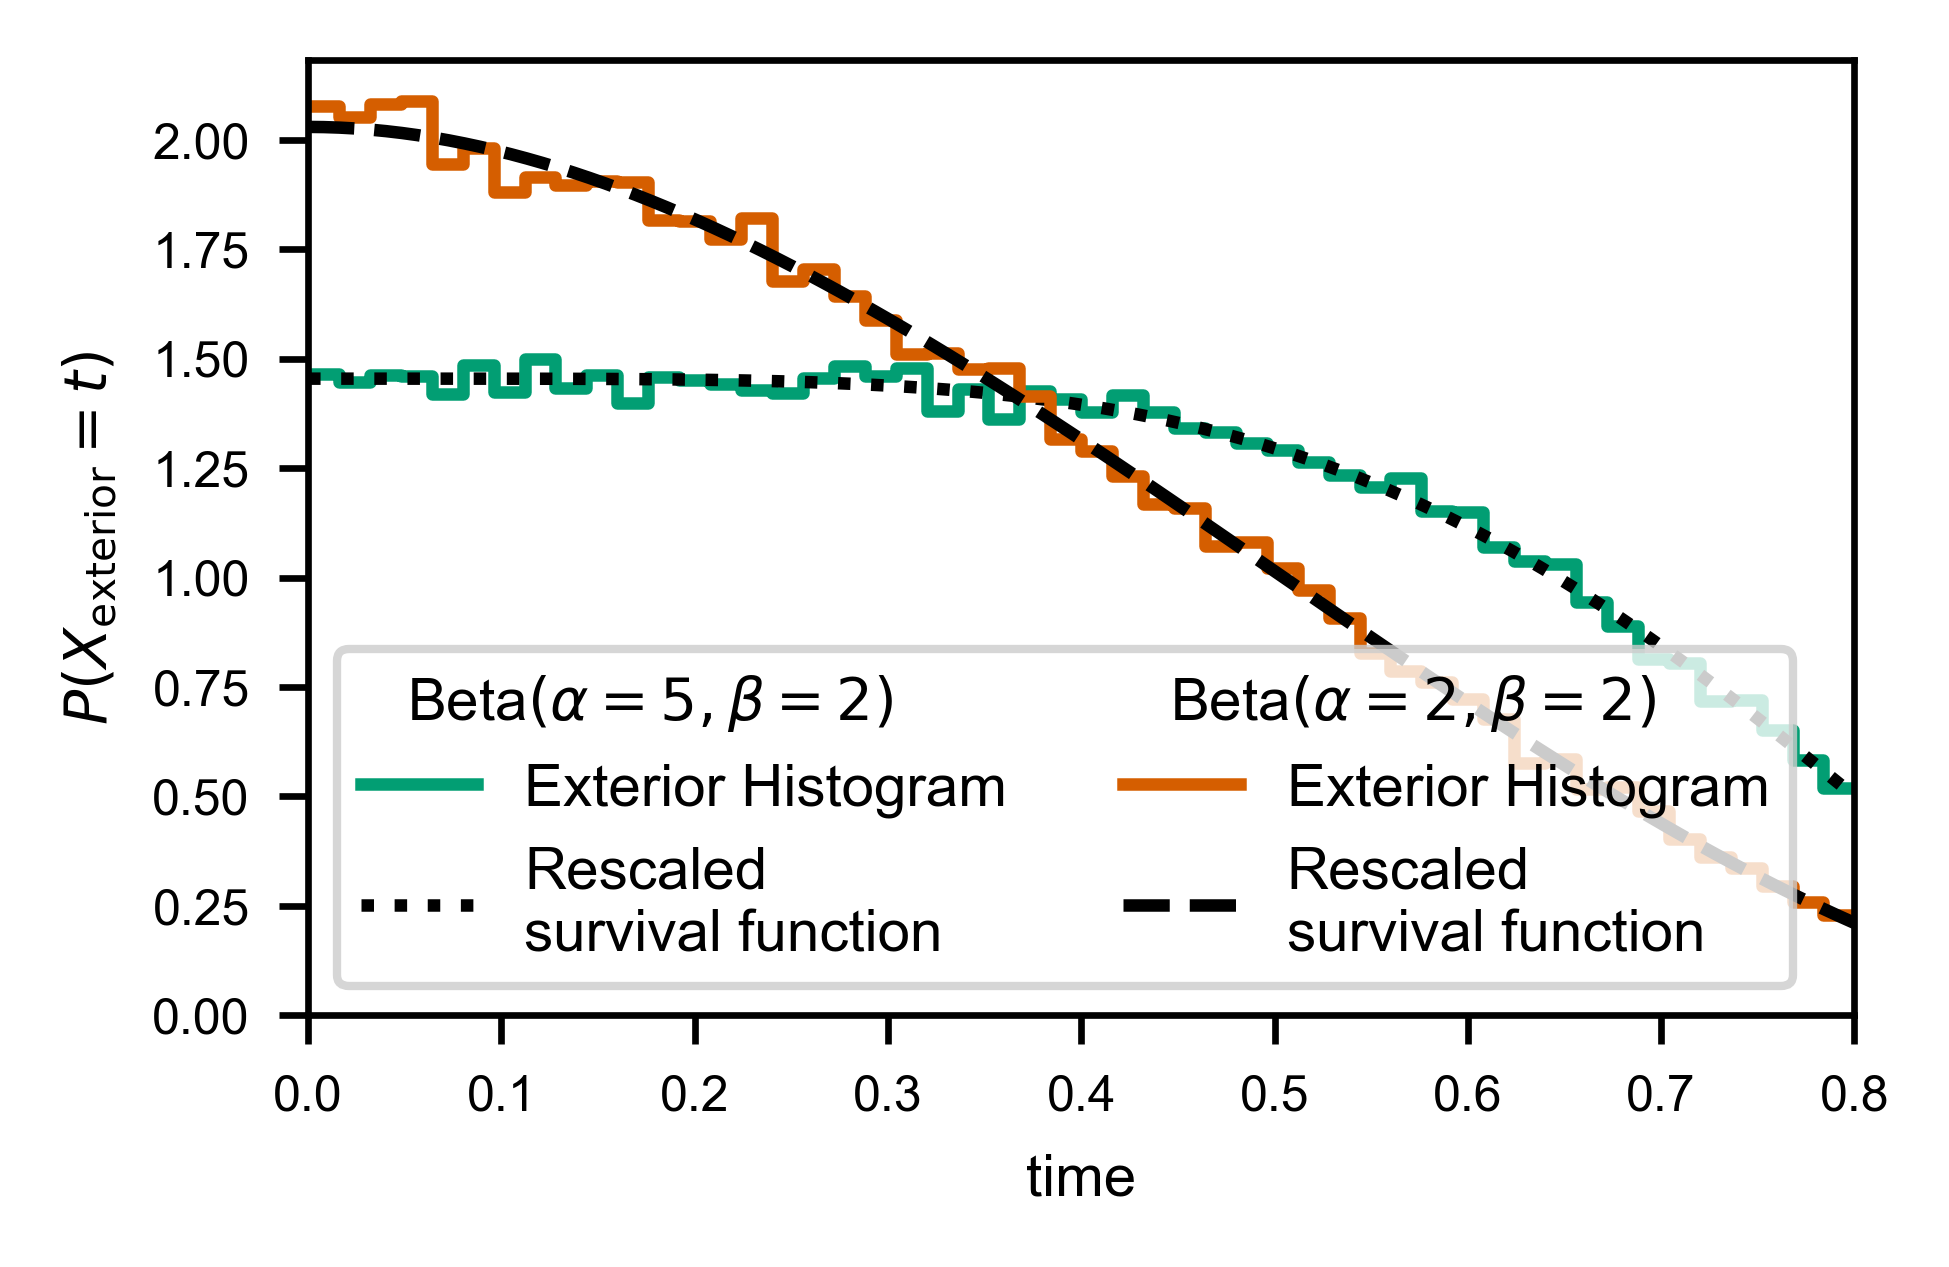

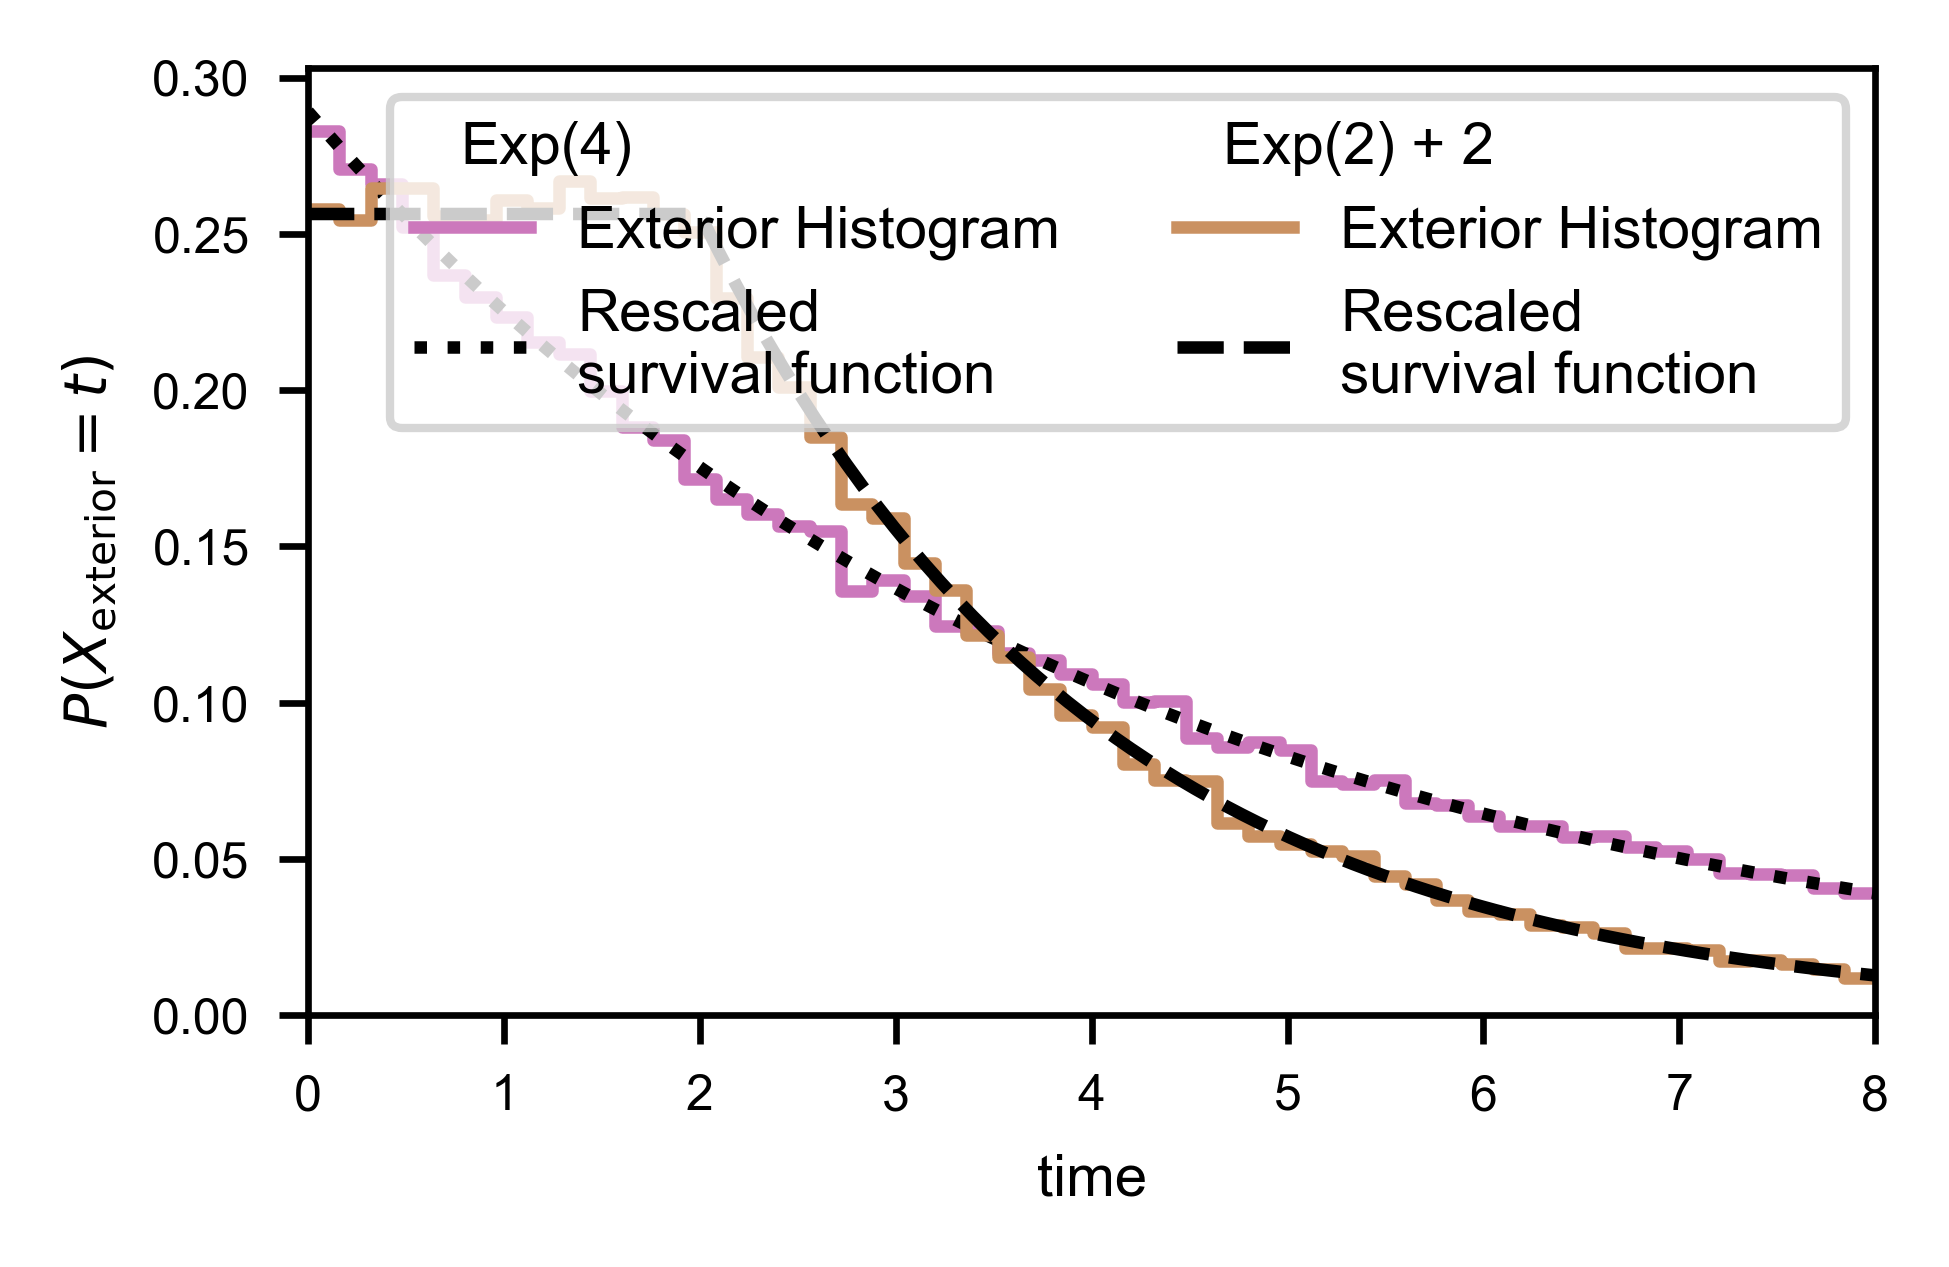

In [8]:
for name, obs in observations.items():
    fplt.exterior_ecdf(obs, variable_pairs[name])

## Interior Times to Likelihood

To handle the interior times, we need simply weight each observed time $t_i$ by $1/(T - t_i)$, which can easily be accomplished using `np.histogram`. (See "Theoretical Details" section below for justification).

Because we only observe times up to $t=T$, we will actually be estimating:

$$ \hat{f}_X(t) \approx P(X = t | X \leq T) = f_X(t) / F_X(T) $$

where $\hat{f}$ is our corrected histogram, and $f_X$ and $F_X$ denote the probability distribution function (PDF) and cumulative distribution functions (CDF) of the random variable $X$, respectively.

### PDF

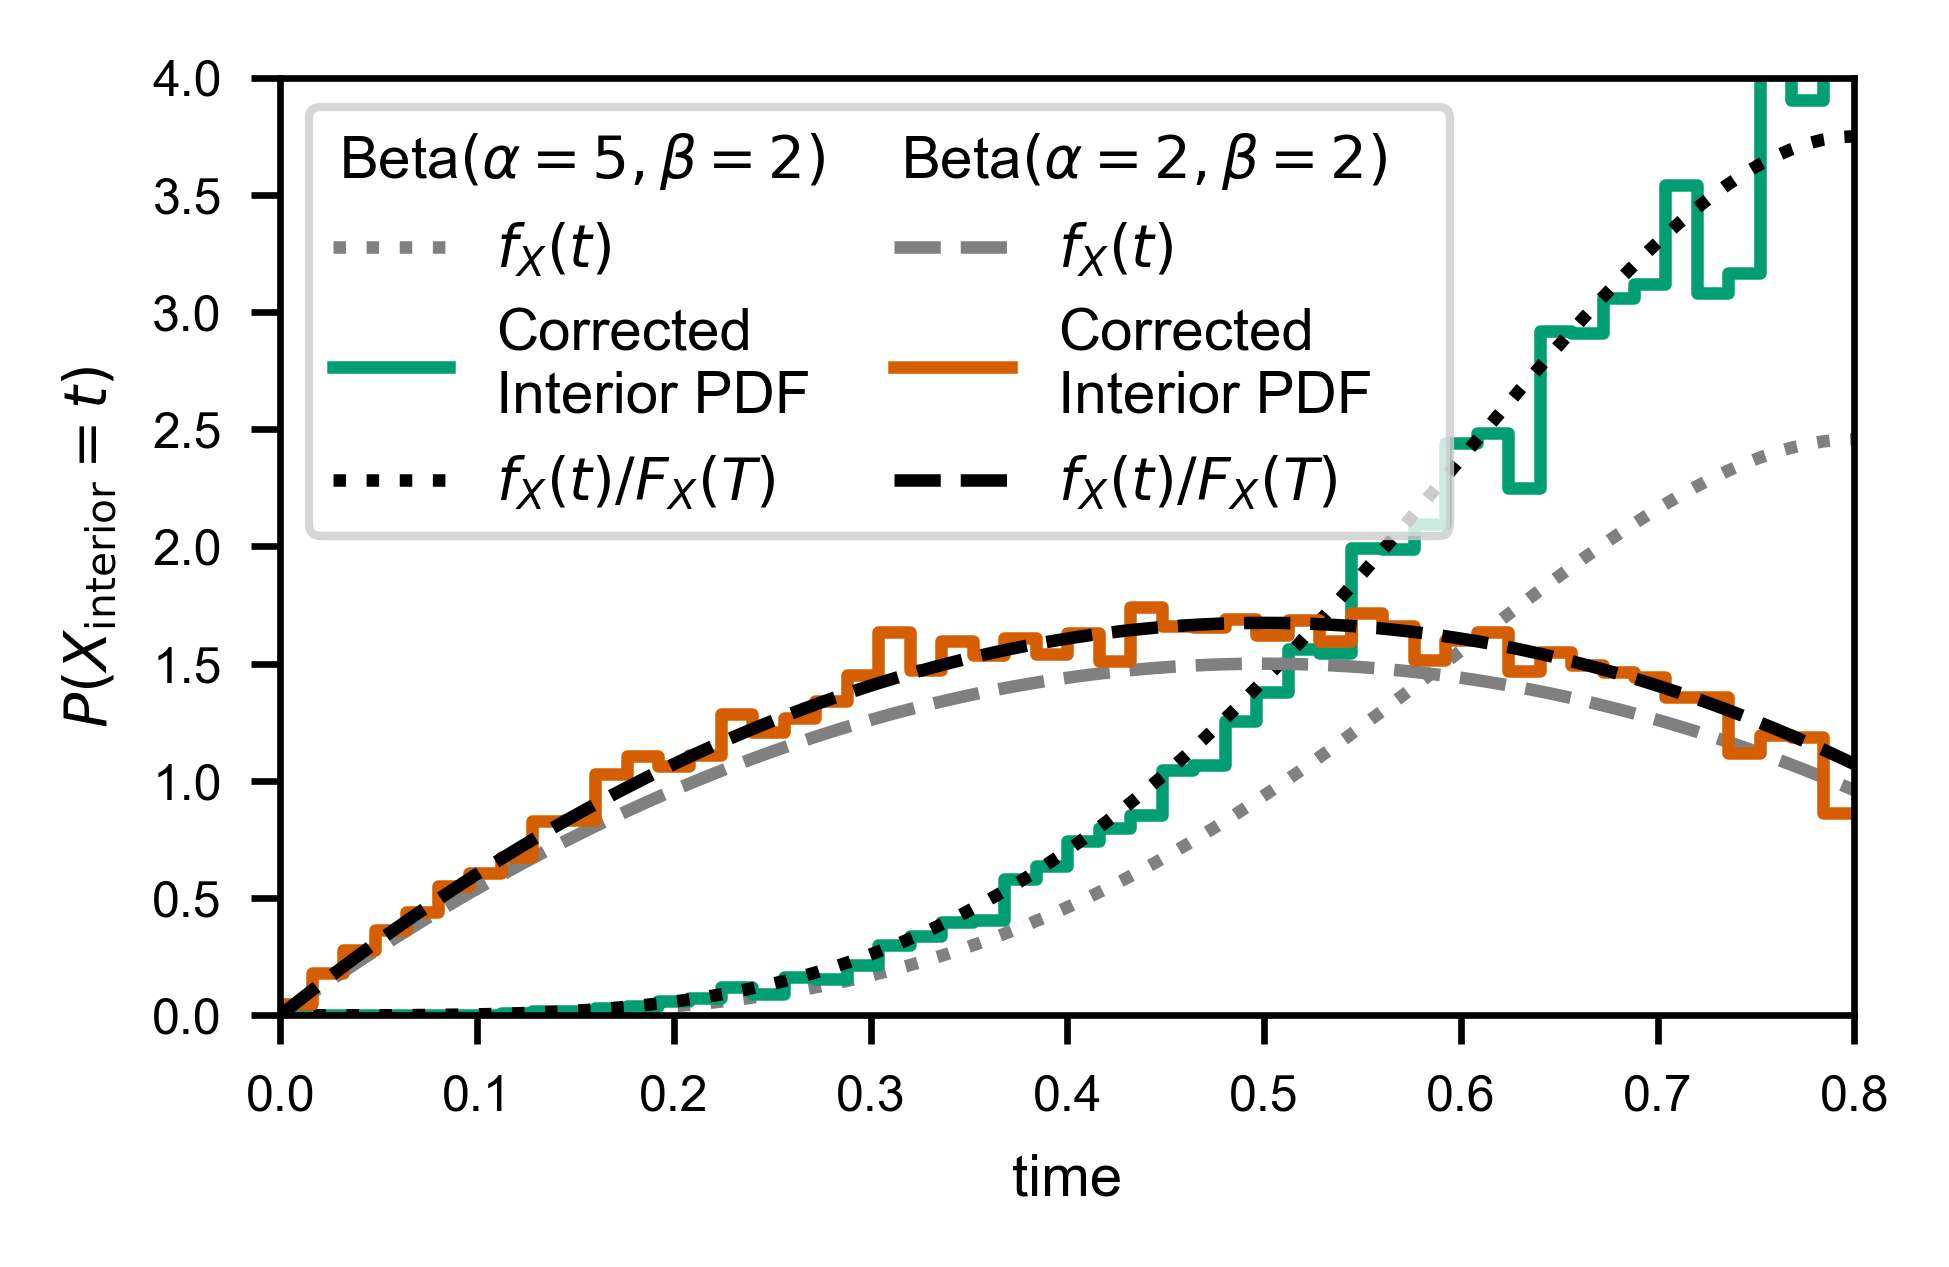

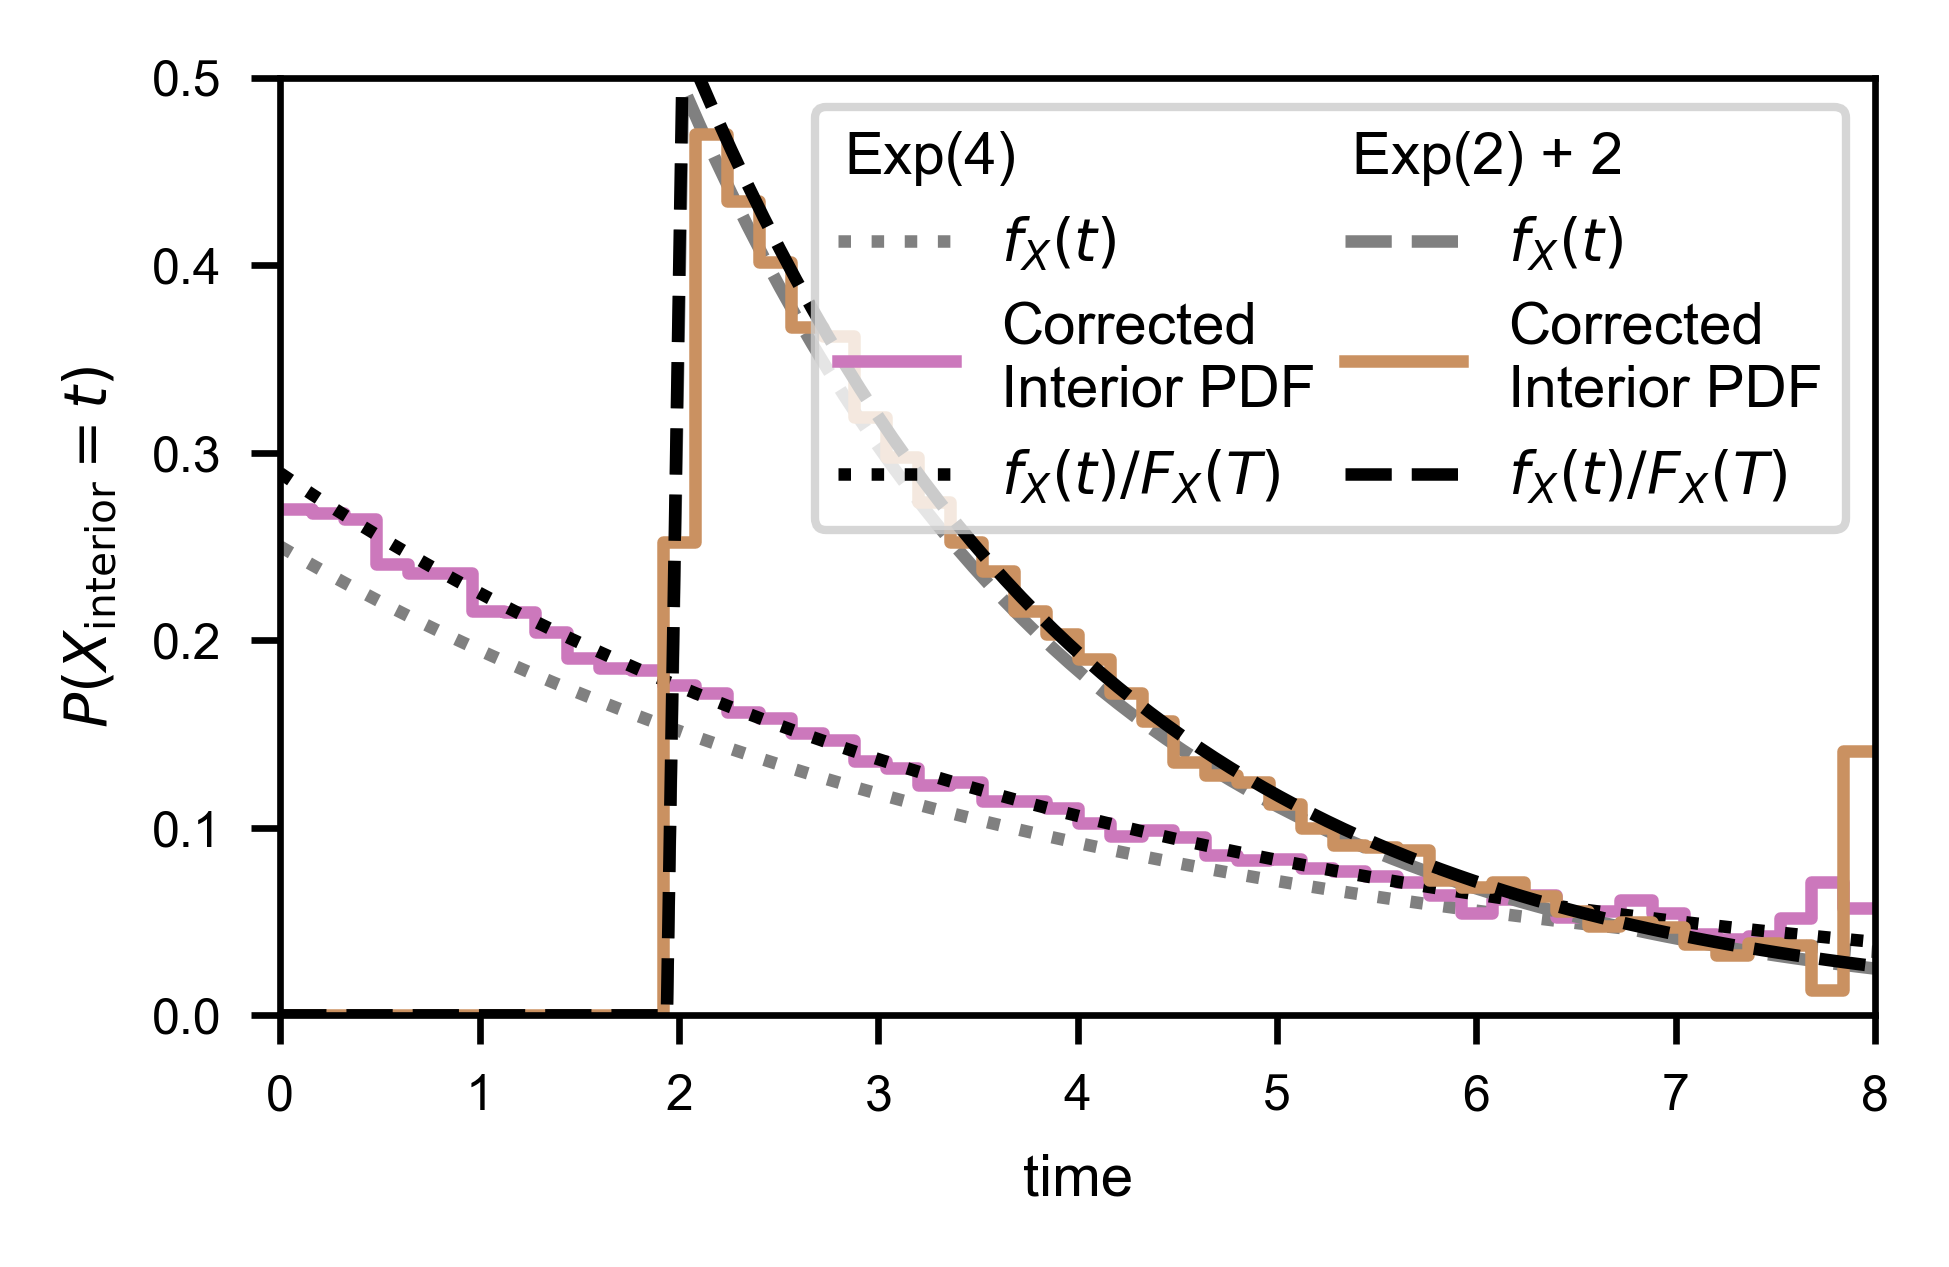

In [9]:
for name, obs in observations.items():
    fplt.corrected_interior_pdf(obs, variable_pairs[name])

### CDF

In [11]:
import importlib
importlib.reload(fw.stats)
importlib.reload(fw)

<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [35]:
import pandas as pd
het_trajs = [
    fw.ab_window(
        [var.rvs for var in var_pair],
        window_size=window, 
        offset=-100*np.sum([var.mean() for var in var_pair]),
        num_replicates=10_000,  
        states=[var.name for var in var_pair]
    )
    for window in np.array([1/2, 1, 2])*0.8
]
het_trajs = pd.concat(het_trajs, ignore_index=True)
multi_T_waits = fw.sim_to_obs(het_trajs, traj_cols=['window_end', 'replicate'])


In [17]:
obs = observations['beta']
var_pair = variable_pairs['beta']
var = var_pair[0]
interior = obs.loc[
    (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
    ['wait_time', 'window_size']
].copy()
x, cdf = fw.ecdf_windowed(
    interior.wait_time.values,
    interior.window_size.values,
    pad_left_at_x=0
)

In [25]:
times_allowed = None
auto_pad_left = False
pad_left_at_x = 0
normalize = True
window_sf = None

# set up y (values to hist) ymax (windows) and x (bins)
# well, the eCDF equivalents, not actually a hist...
y = interior.wait_time.values
ymax = interior.window_size.values
y = np.array(y)
ymax = np.array(ymax)
# variables only needed for multiple window sizes
ignore_window_sf = False
uniq_ymax = None
# allow providing single window size
if ymax.size == 1:
    ignore_window_sf = True
    ymax = ymax*np.ones_like(y)
i = np.argsort(y)
y = y[i]
ymax = ymax[i]
if times_allowed is not None:
    x = np.unique(times_allowed)
else:
    x = np.unique(y)
x.sort()
if auto_pad_left:
    dx = np.mean(np.diff(x))
    x = np.insert(x, 0, x[0] - dx)
elif pad_left_at_x is not None:
    if x[0] <= pad_left_at_x:
        warnings.warn('pad_left_at_x not left of x in ecdf_windowed! '
                      'Ignoring...')
    else:
        x = np.insert(x, 0, pad_left_at_x)

num_obs = len(y)
cdf = np.zeros(x.shape, dtype=np.dtype('float'))
if not ignore_window_sf and window_sf is None:
    # get fraction of windows that are at *least* of each width
    uniq_ymax, window_ecdf = mla.stats.ecdf(ymax, pad_left_at_x=0)
    window_sf = 1 - window_ecdf
weights = (ymax - y)
if not ignore_window_sf:
    # for each observed time, we can get number of windows in which it can
    # have been observed
    if uniq_ymax is None:
        # don't forget to pad_left_at_x=0
        uniq_ymax = np.insert(np.unique(ymax), 0, 0)
    # minus 1 because of how searchsorted returns indices
    window_i = np.searchsorted(uniq_ymax, y)
    frac_trajs_observable = window_sf[window_i]
    weights = weights*frac_trajs_observable
full_cdf = np.cumsum(1/weights)  # before repeats removed
i = 0
for xi, xx in enumerate(x):
    while i + 1 < num_obs and np.isclose(y[i+1], xx):
        i += 1
    cdf[xi] = full_cdf[i]
if normalize:
    cdf = cdf/full_cdf[-1]


In [36]:
uniq_ymax

array([0. , 0.8])

In [37]:
window_sf

array([0., 1.])

In [31]:
window_i

array([0, 0, 0, ..., 0, 0, 0])

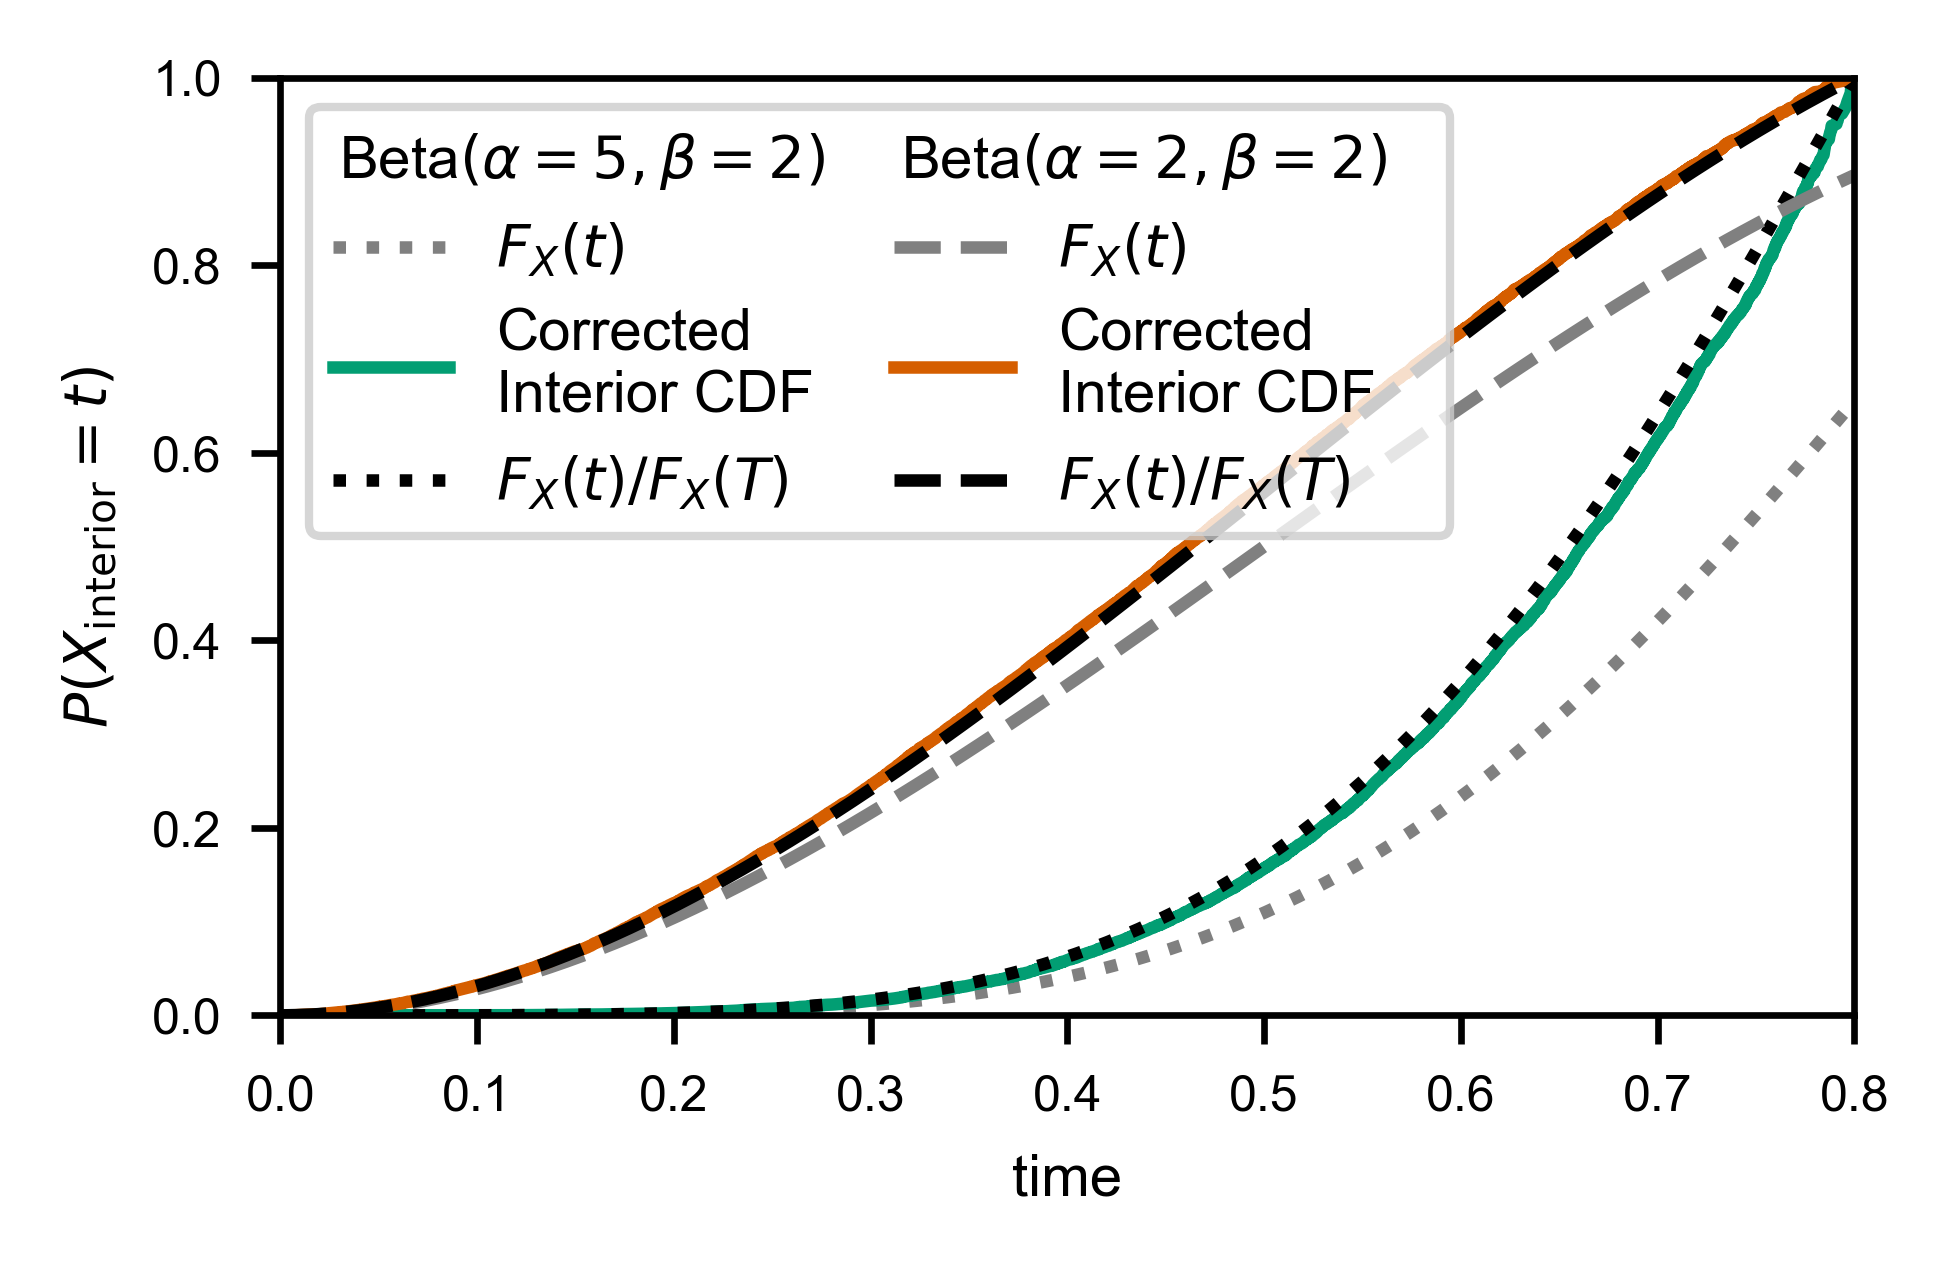

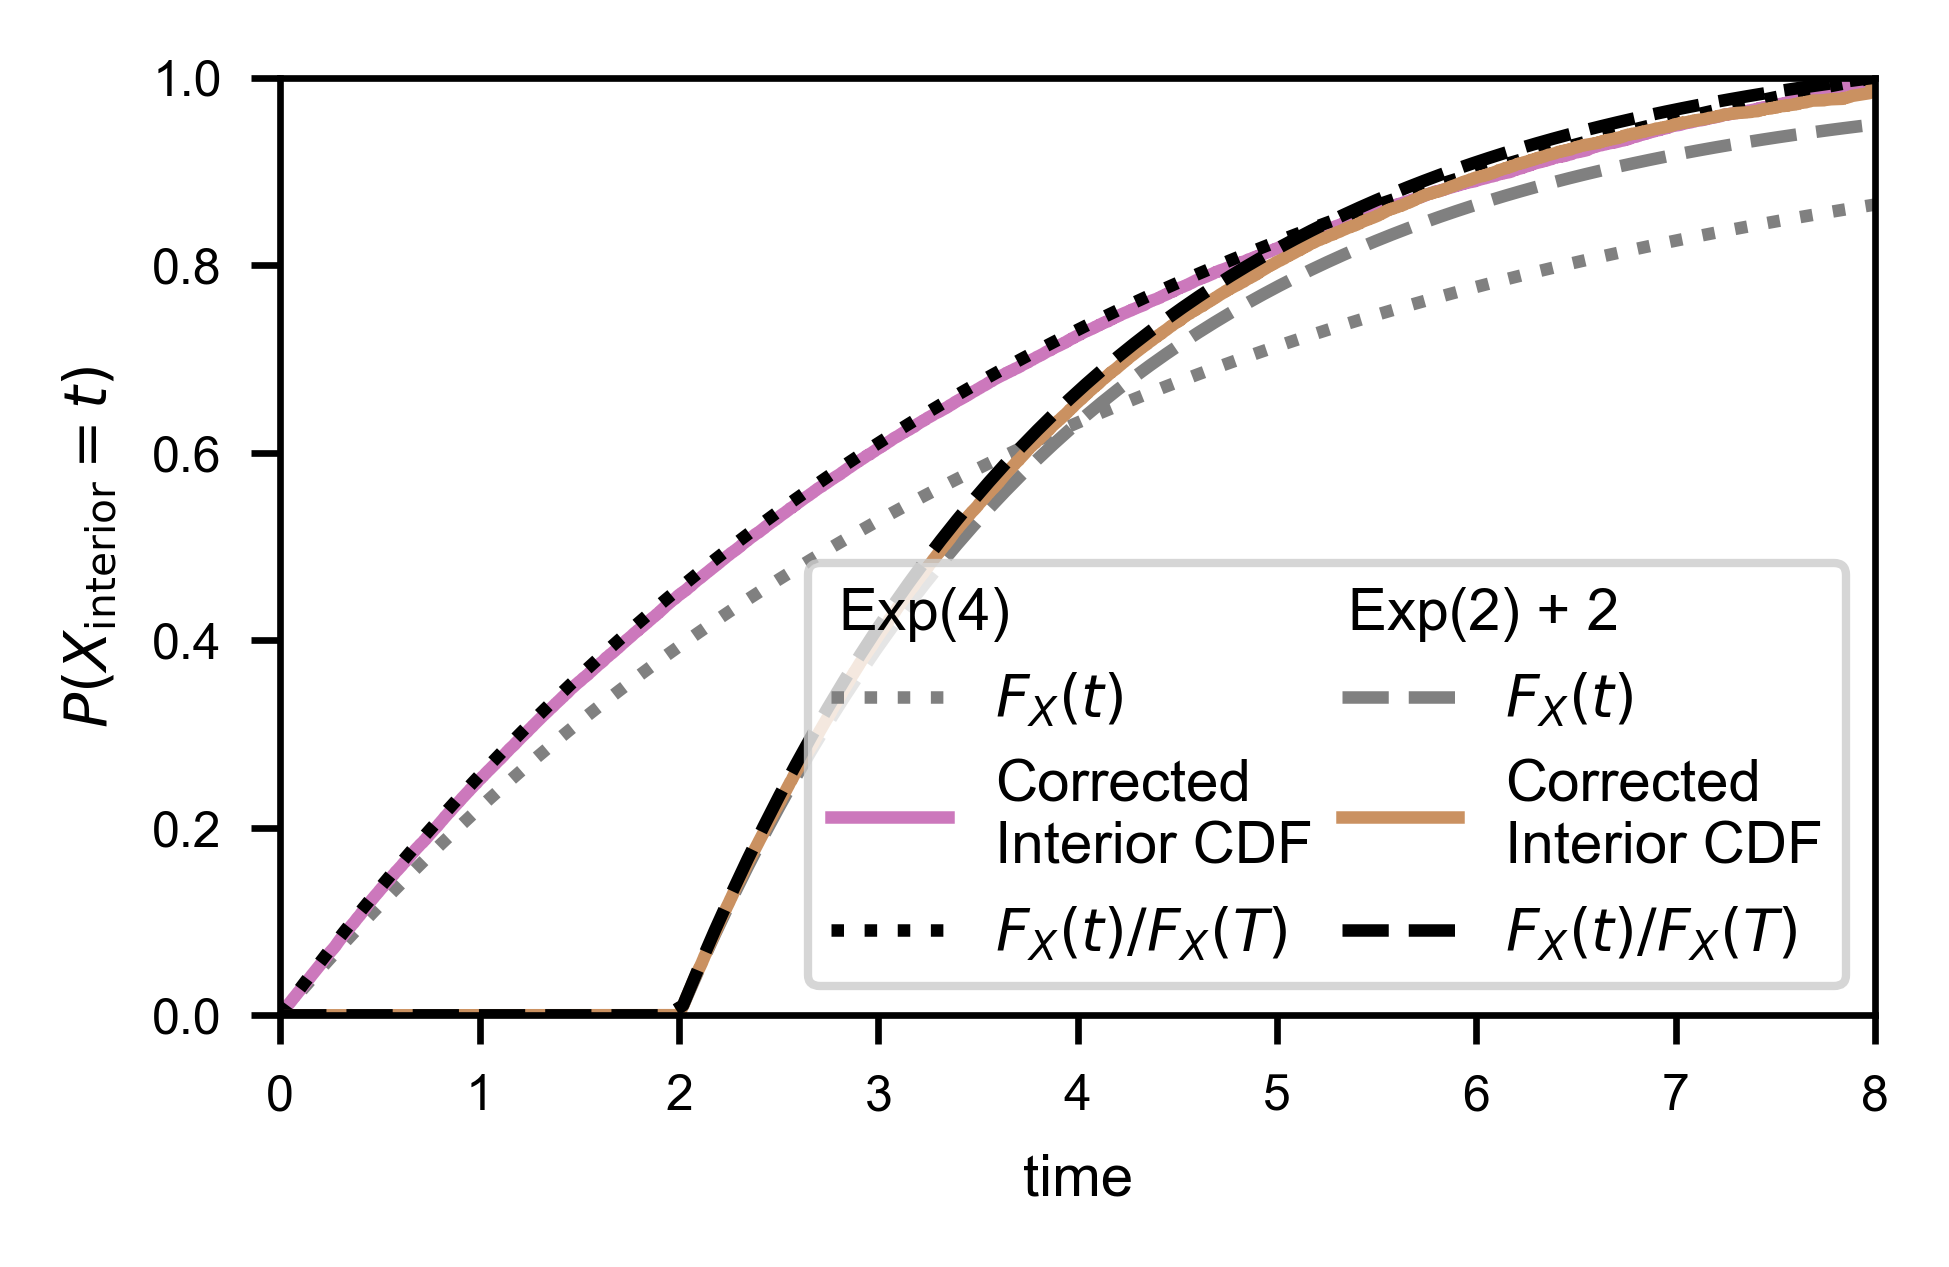

In [12]:
for name, obs in observations.items():
    fplt.corrected_interior_ecdf(obs, variable_pairs[name])

## Interior *and* Exterior times to "real" distribution

Here's how well we are able to rescale $Z_X$ and into $\int_0^t F_X(t) dt$ for this particular set of trajectories:

### Correction factor

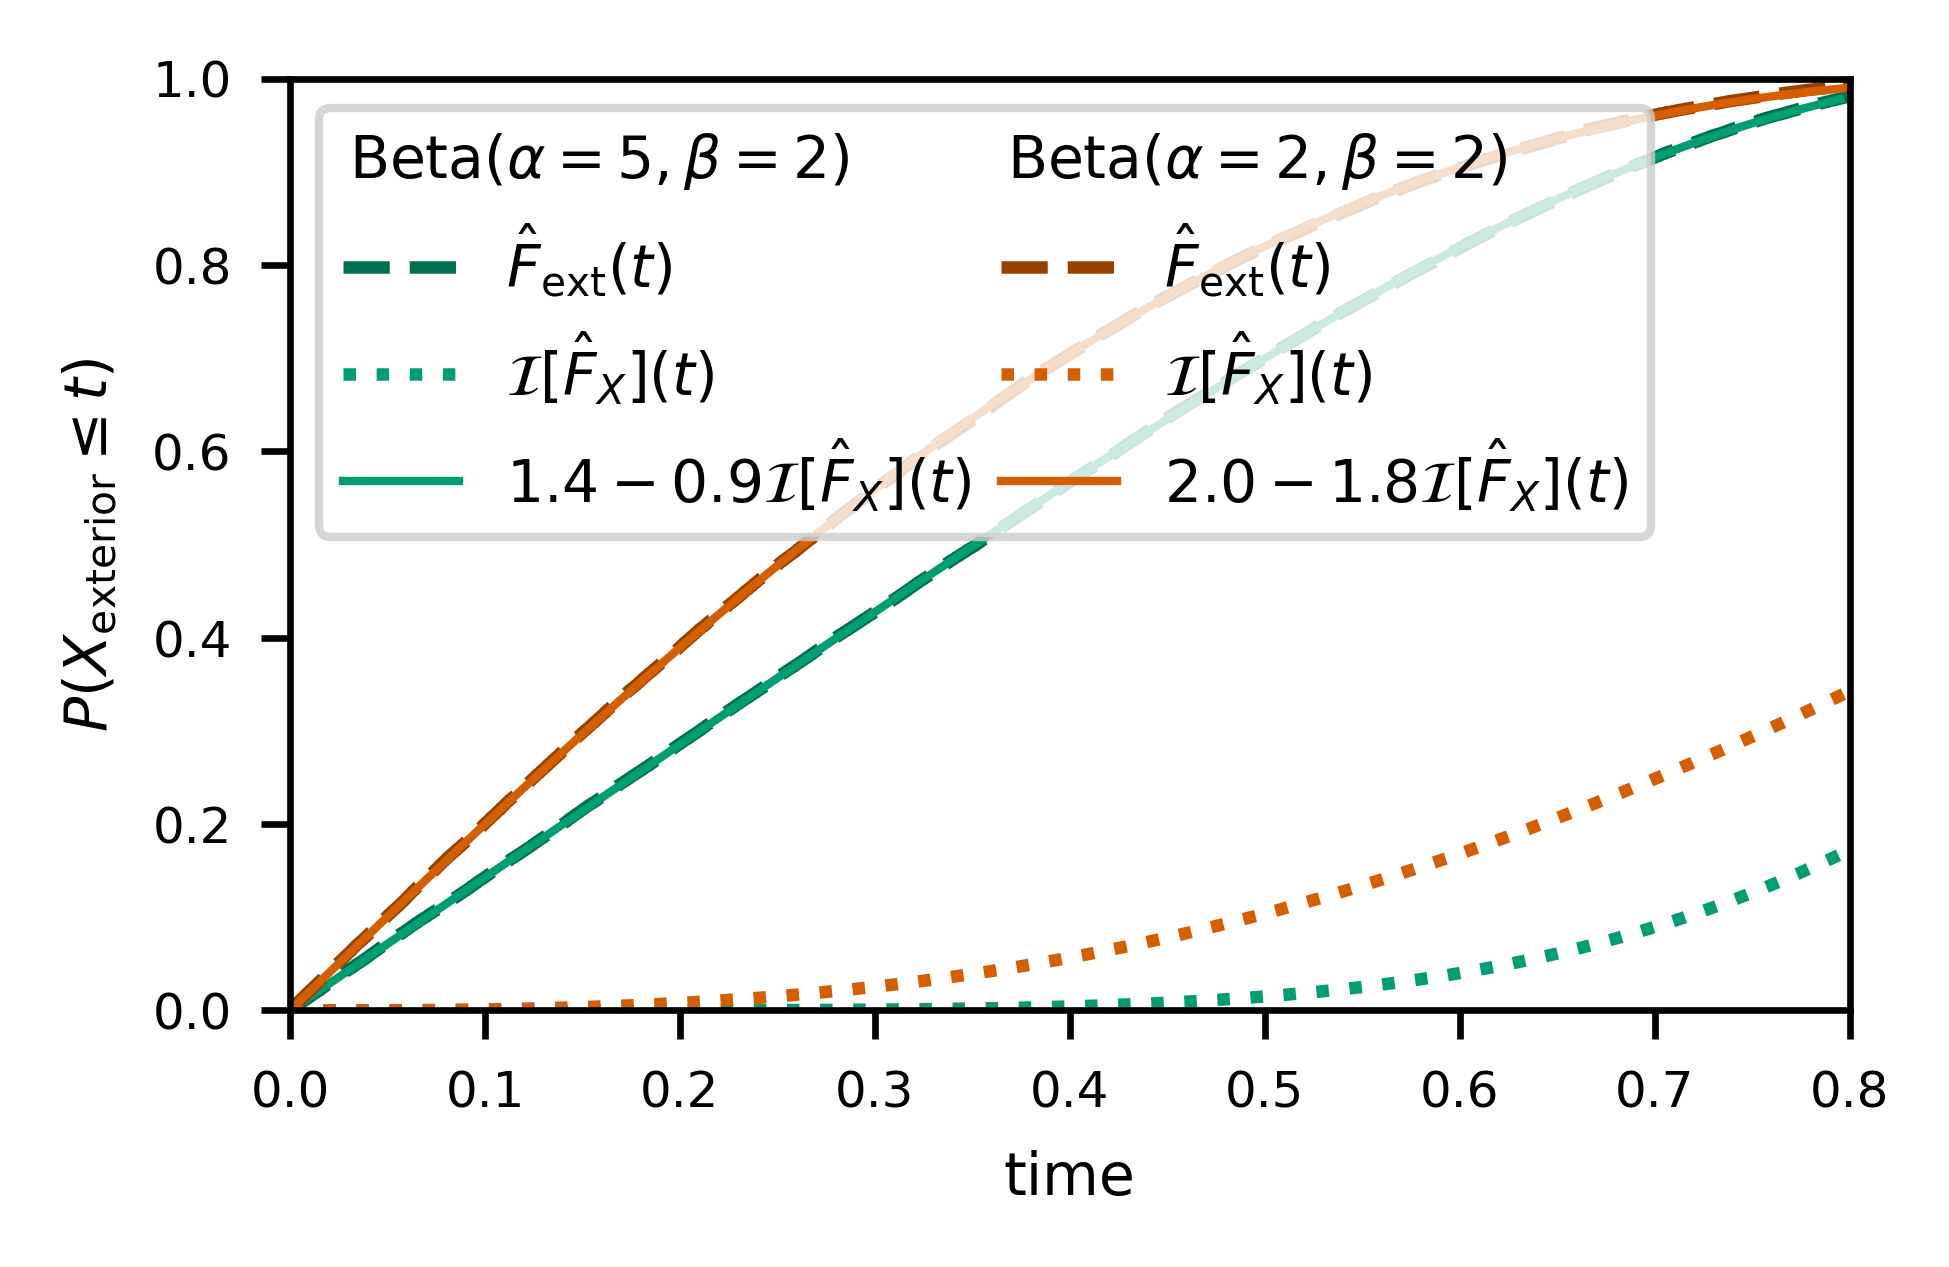

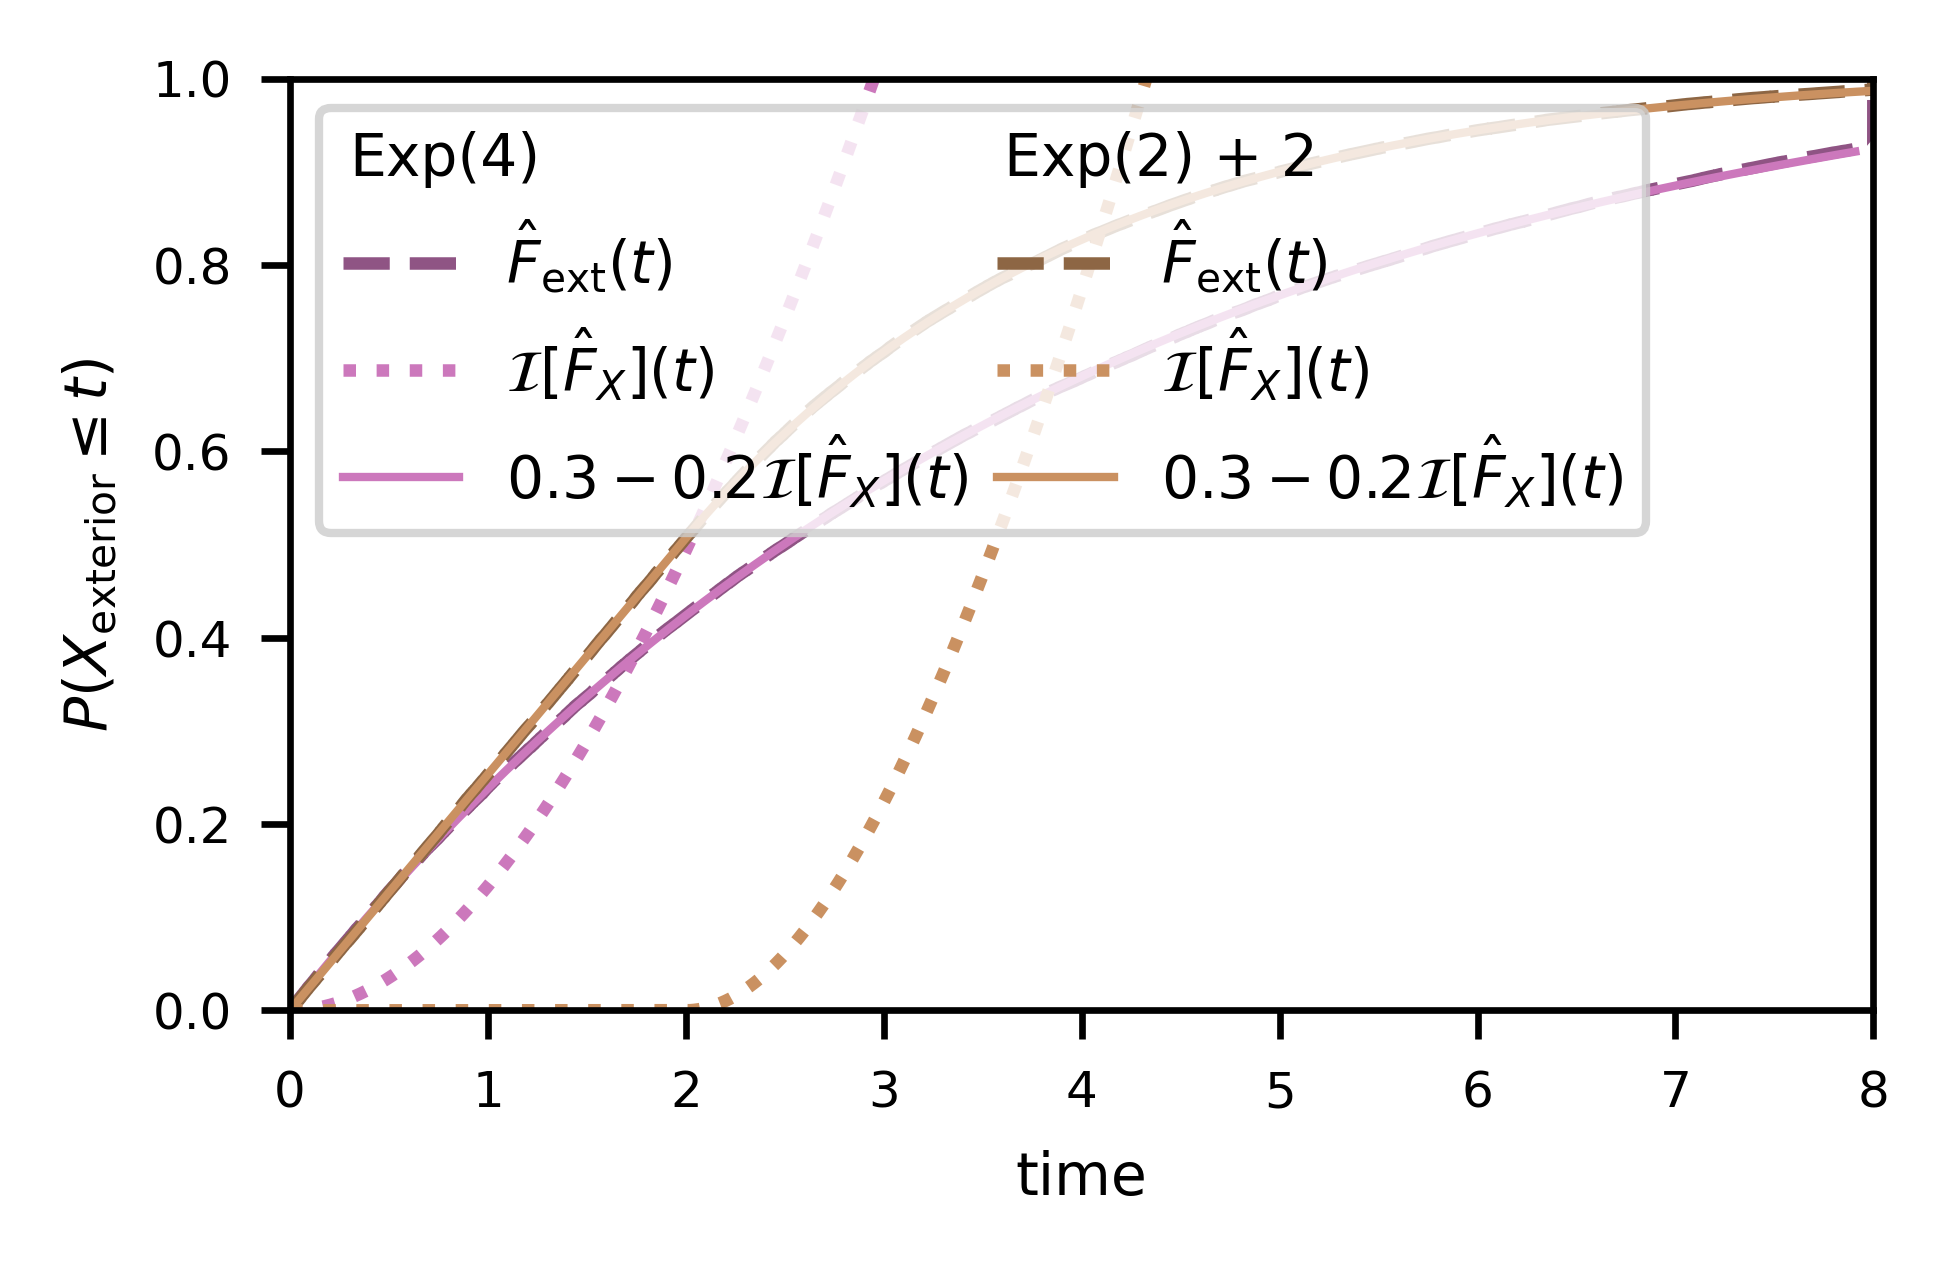

In [152]:
for name, obs in observations.items():
    fplt.scaling_normalizers(obs, variable_pairs[name])

Now we can compute correctly normalized wait time distributions:

In [61]:
importlib.reload(fw)

<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [62]:
window_sizes = obs.groupby('replicate')['window_size'].first().sort_values().values
window_sizes, window_cdf = stats.ecdf(window_sizes, pad_left_at_x=0)
window_sf = 1 - window_cdf


In [63]:
window_sf

array([1., 0.])

In [64]:
for name, obs in observations.items():
    plt.figure()
    for var in var_pair:
        exterior = obs.loc[
            (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
            ['wait_time', 'window_size']
        ].copy()
        interior = obs.loc[
            (obs['state'] == var.name) 
            & (obs['wait_type'] != 'interior')
            & (obs['wait_type'] != 'full exterior'),
            ['wait_time', 'window_size']
        ].copy()
        window_sizes = obs.groupby('replicate')['window_size'].first().values
        # now sorted
        window_sizes, window_cdf = stats.ecdf(window_sizes)
        window_sf = 1 - window_cdf
        t, rcdf = fw.ecdf_ext_int(
            exterior.wait_time.values, 
            interior.wait_time.values,
            interior.window_size.values
        )
        plt.plot(t, rcdf)

ValueError: Unable to compute F_X(T)!

<Figure size 1879.2x1409.4 with 0 Axes>

In [ ]:
%debug

NameError: name 'cdf_int_to_ext_cdf' is not defined

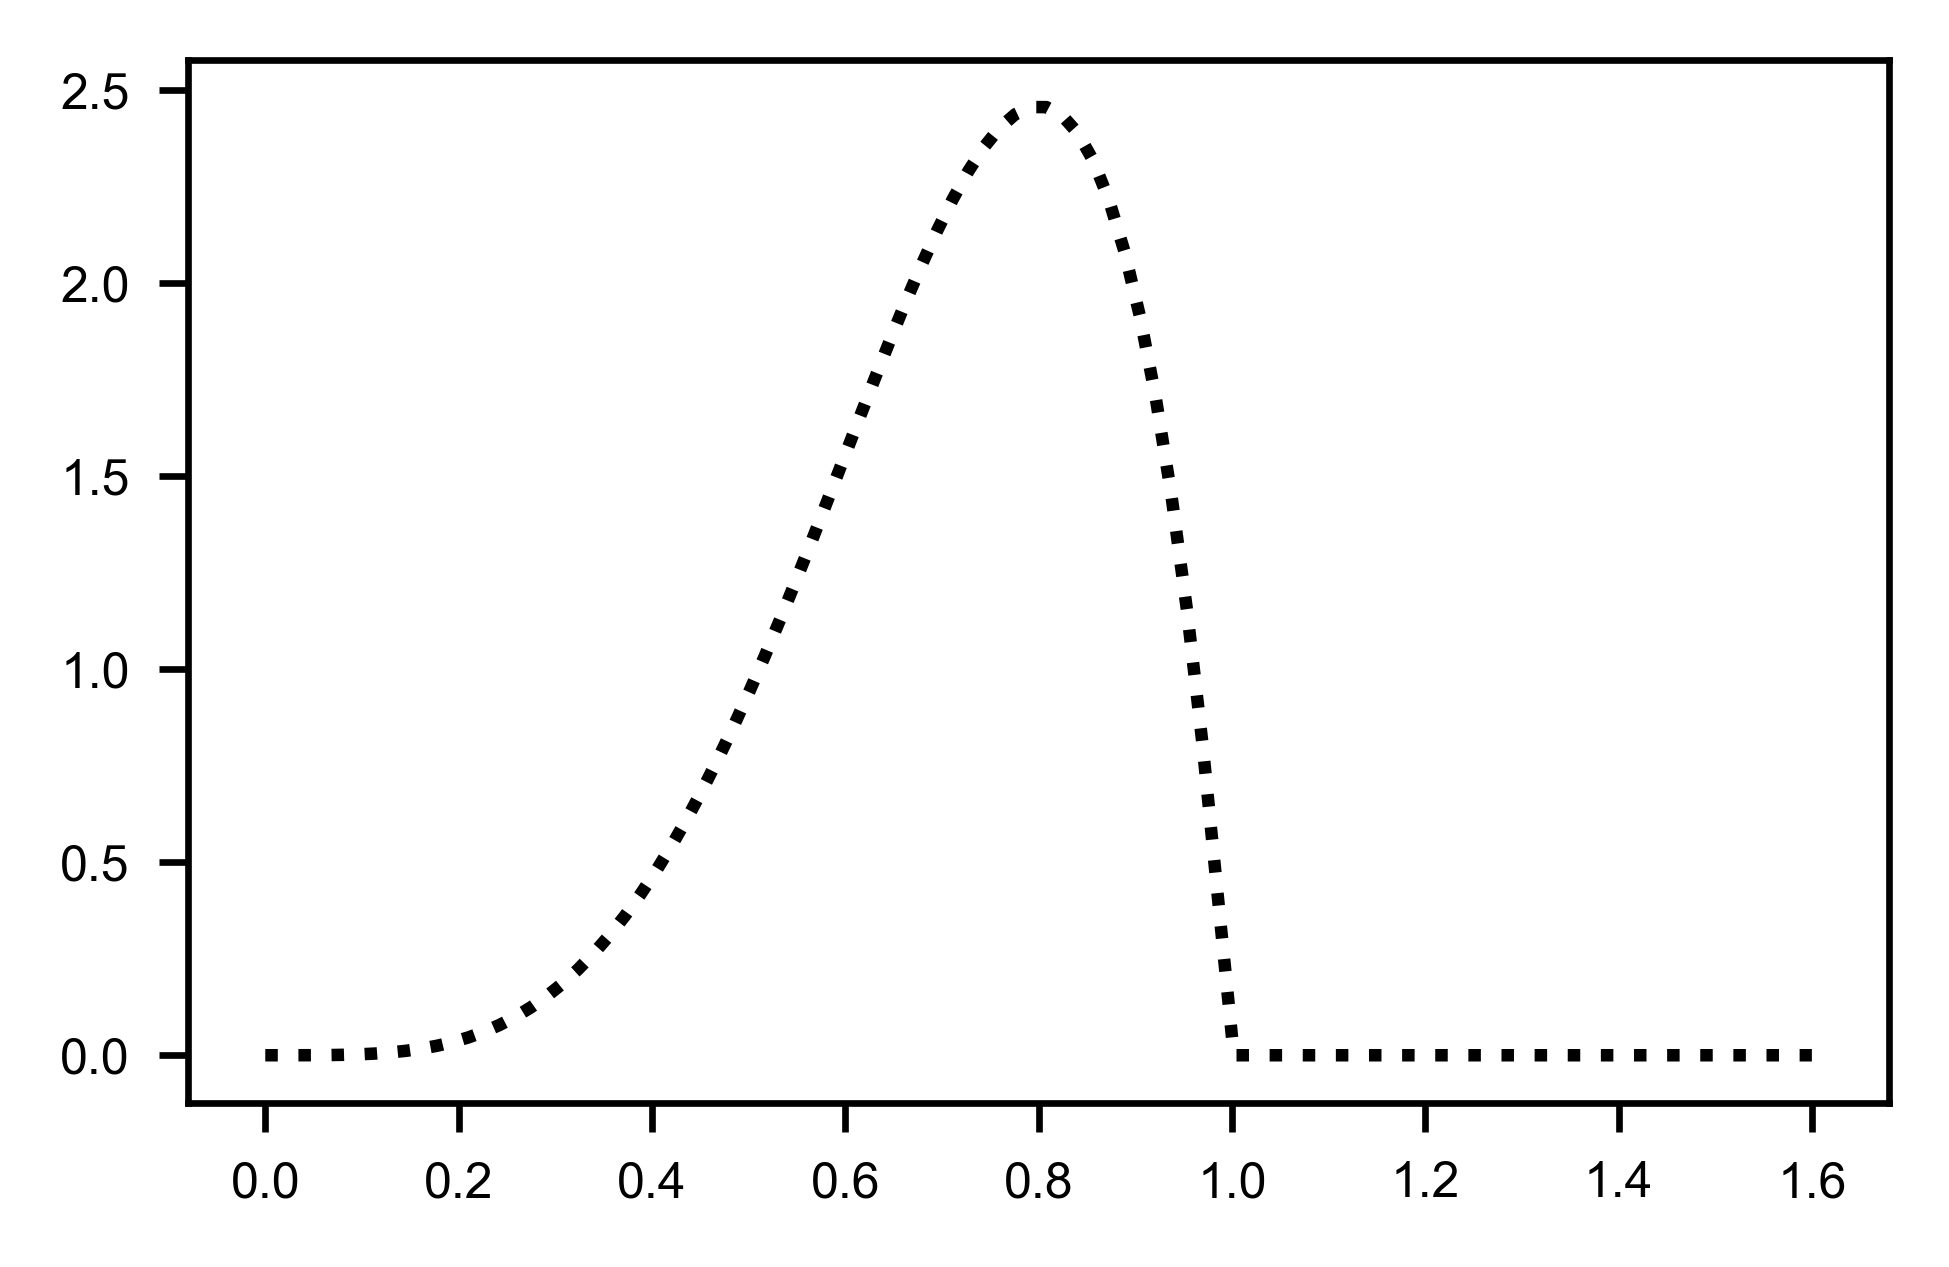

In [45]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in var_pair}
T = obs.window_size.max()
for var in var_pair:
    line, = ax.plot(t, var.pdf(t), ls=var.linestyle,
                    c='k', label=f'True $f_X(t)$')
    legend_entries[var.name].append(line)
    
    
    interior = obs.loc[
        (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)

    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = stats.bars_given_hist(y, t_bins)
    a = cdf_int_to_ext_cdf[var.name]['a']
    b = cdf_int_to_ext_cdf[var.name]['b']
    line, = ax.plot(X, Y*(-b/a), c=var.color, label='Fully Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 2.5])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

### Heterogeneous Window Size

For arbitrary collections of data measured with potentially different window sizes, we simply need to correct for the fraction of trajectories in which each time could have been observed at all.


In [39]:
# generate same distribution, but with three different window sizes
example_window=0.8
het_trajs = [
    fw.ab_window(
        [var.rvs for var in var_pair],
        window_size=window, 
        offset=-100*np.sum([var.mean() for var in var_pair]),
        num_replicates=10_000,  
        states=[var.name for var in var_pair]
    )
    for window in np.array([1/2, 1, 2])*example_window
]
import pandas as pd
het_trajs = pd.concat(het_trajs, ignore_index=True)
multi_T_waits = het_trajs \
    .groupby(['window_end', 'replicate']) \
    .apply(fw.traj_to_waits)
del multi_T_waits['replicate']
del multi_T_waits['window_end']
multi_T_waits.head()

state  start_time  end_time  \
window_end replicate rank_order                                     
0.4        0         0           Beta(2, 2)   -0.541396  0.216556   
                     1           Beta(5, 2)    0.216556  1.109685   
           1         0           Beta(5, 2)   -0.258833  0.339608   
                     1           Beta(2, 2)    0.339608  0.629859   
           2         0           Beta(5, 2)   -0.252040  0.587380   

                                 window_start  wait_time  window_size  \
window_end replicate rank_order                                         
0.4        0         0                      0   0.216556          0.4   
                     1                      0   0.941396          0.4   
           1         0                      0   0.339608          0.4   
                     1                      0   0.658833          0.4   
           2         0                      0   0.652040          0.4   

                                      wait_type  
window_end replicate rank_order                  
0.4        0         0            left exterior  
                     1           right exterior  
           1         0            left exterior  
                     1           right exterior  
           2         0            full exterior

Notice the only difference is that the weights also include the fraction of **trajectories** that can have even observed the given wait time in the first place.

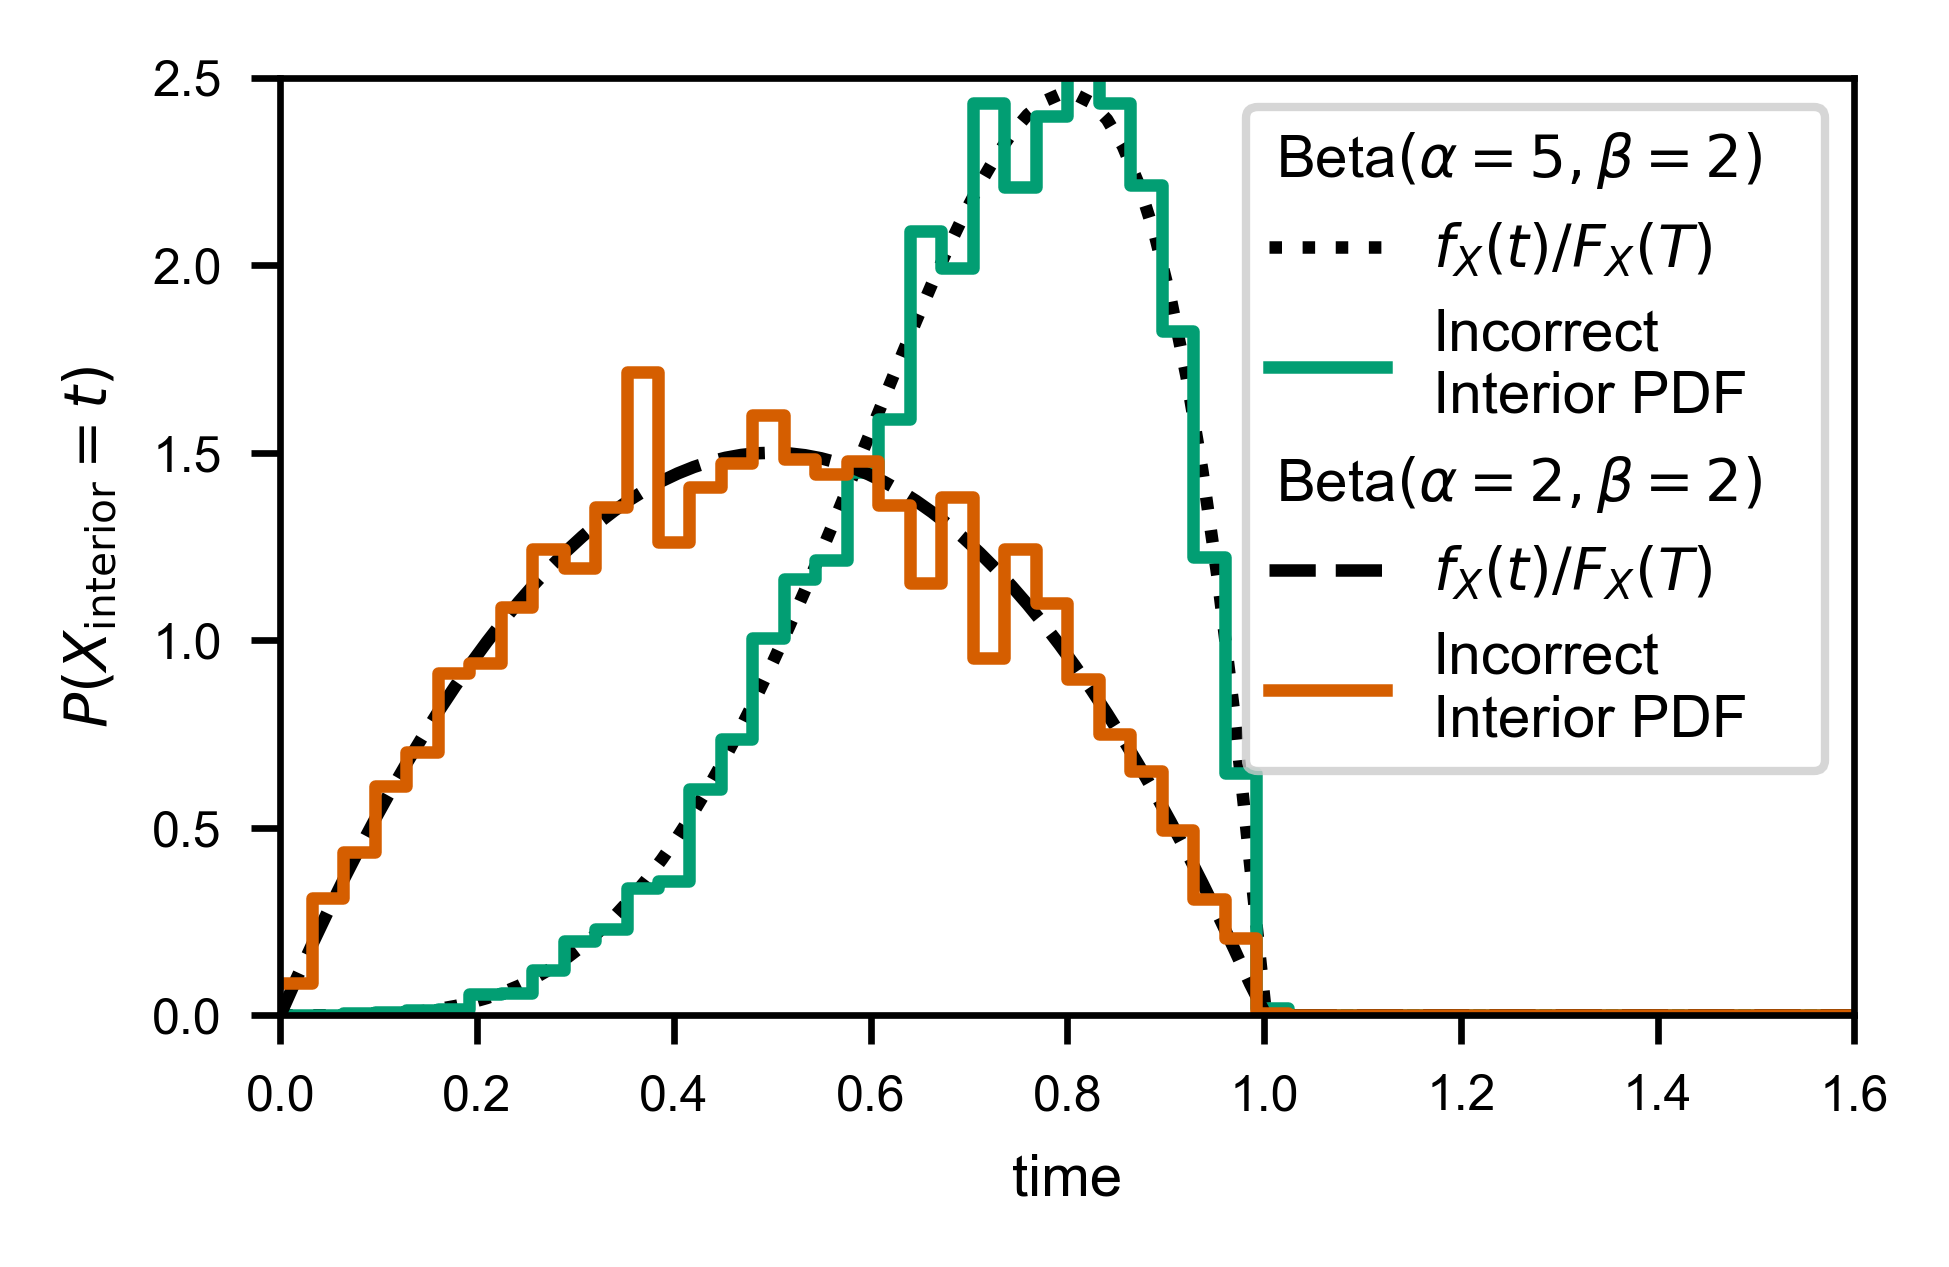

In [43]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in var_pair}
T = multi_T_waits.window_size.max()
# get fraction of windows that are at *least* of each width
window_sizes, window_cumulant = fw.ecdf(
    multi_T_waits.groupby(['window_end', 'replicate'])['window_size'].first().values, 
    pad_left_at_x=0
)
window_frac_at_least = 1 - window_cumulant
for var in var_pair:
    t = np.linspace(0, T, 100)

    line, = ax.plot(t, var.pdf(t)/var.cdf(T), ls=var.linestyle,
                    c='k', label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    # for each observed time, we can get number of windows in which it can have been observed
    window_i = np.searchsorted(window_sizes, interior.wait_time) - 1
    frac_trajs_observable = window_frac_at_least[window_i]
    interior['correction'] = 1 / frac_trajs_observable / (interior.window_size - interior.wait_time)
       
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = stats.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Incorrect\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 2.5])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1, loc='upper right')

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for i in [0, 3]:
        hpack = vpack.get_children()[i]
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

Here's what it looks like if we don't do the extra correction. Notice the "jumps" at each window size, due to the missing correction factor:

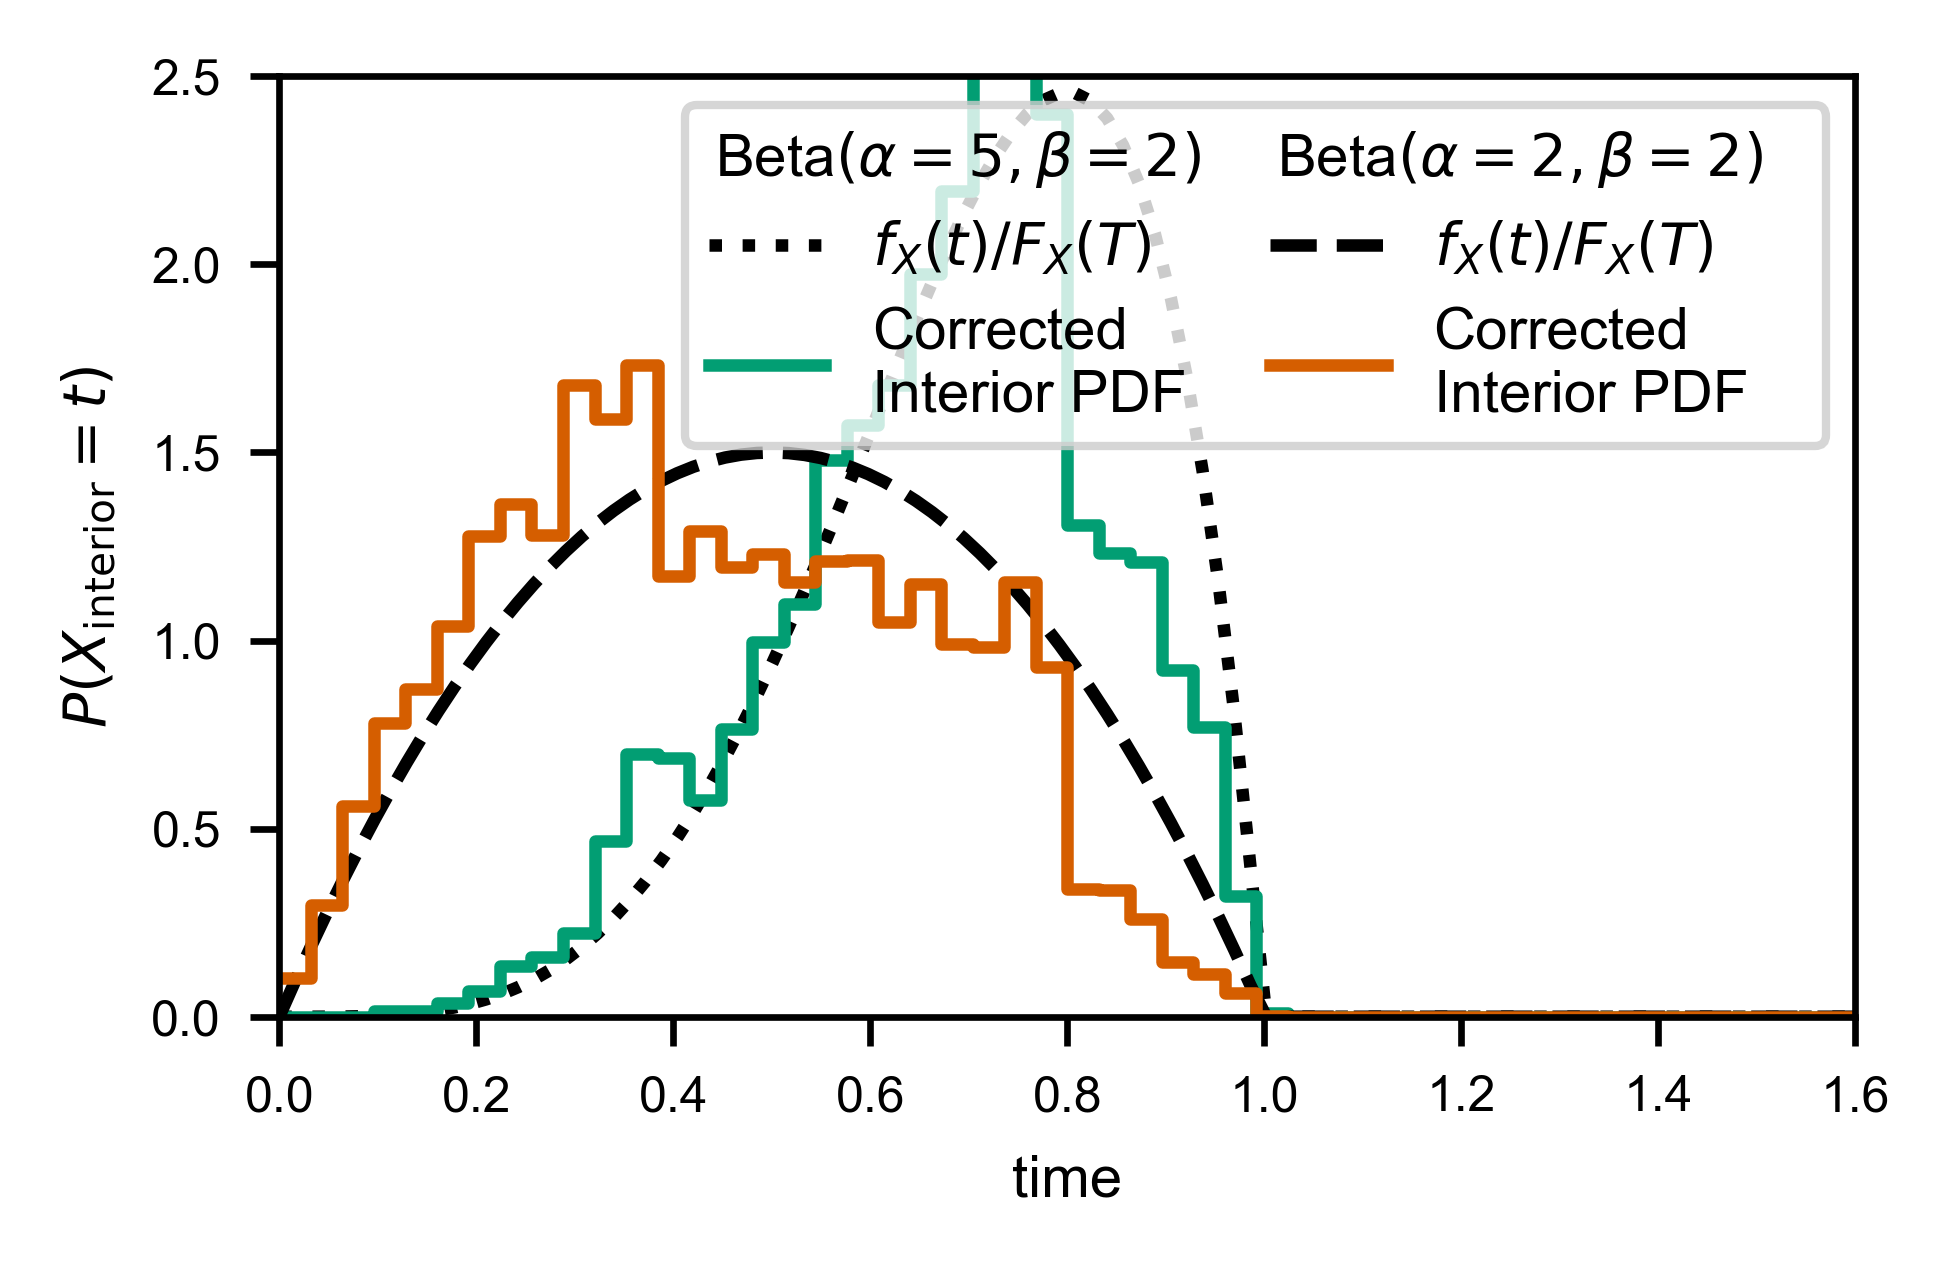

In [760]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in var_pair}
T = multi_T_waits.window_size.max()
for var in var_pair:
    t = np.linspace(0, T, 100)

    line, = ax.plot(t, var.pdf(t)/var.cdf(T), ls=var.linestyle,
                    c='k', label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)
       
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = stats.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y*(-b/a), c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 2.5])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

As you might expect, ``fw.ecdf_windowed`` takes a ``window_cumulant`` argument, to allow you to specify how many of each window type there are (since it's not possible to infer that information purely from a list of interior times and corresponding window sizes).

If your window size is drawn randomly, then each window size is effectively unique, and the default value of ``window_cumulant=None`` will do the appropriate computation for you.

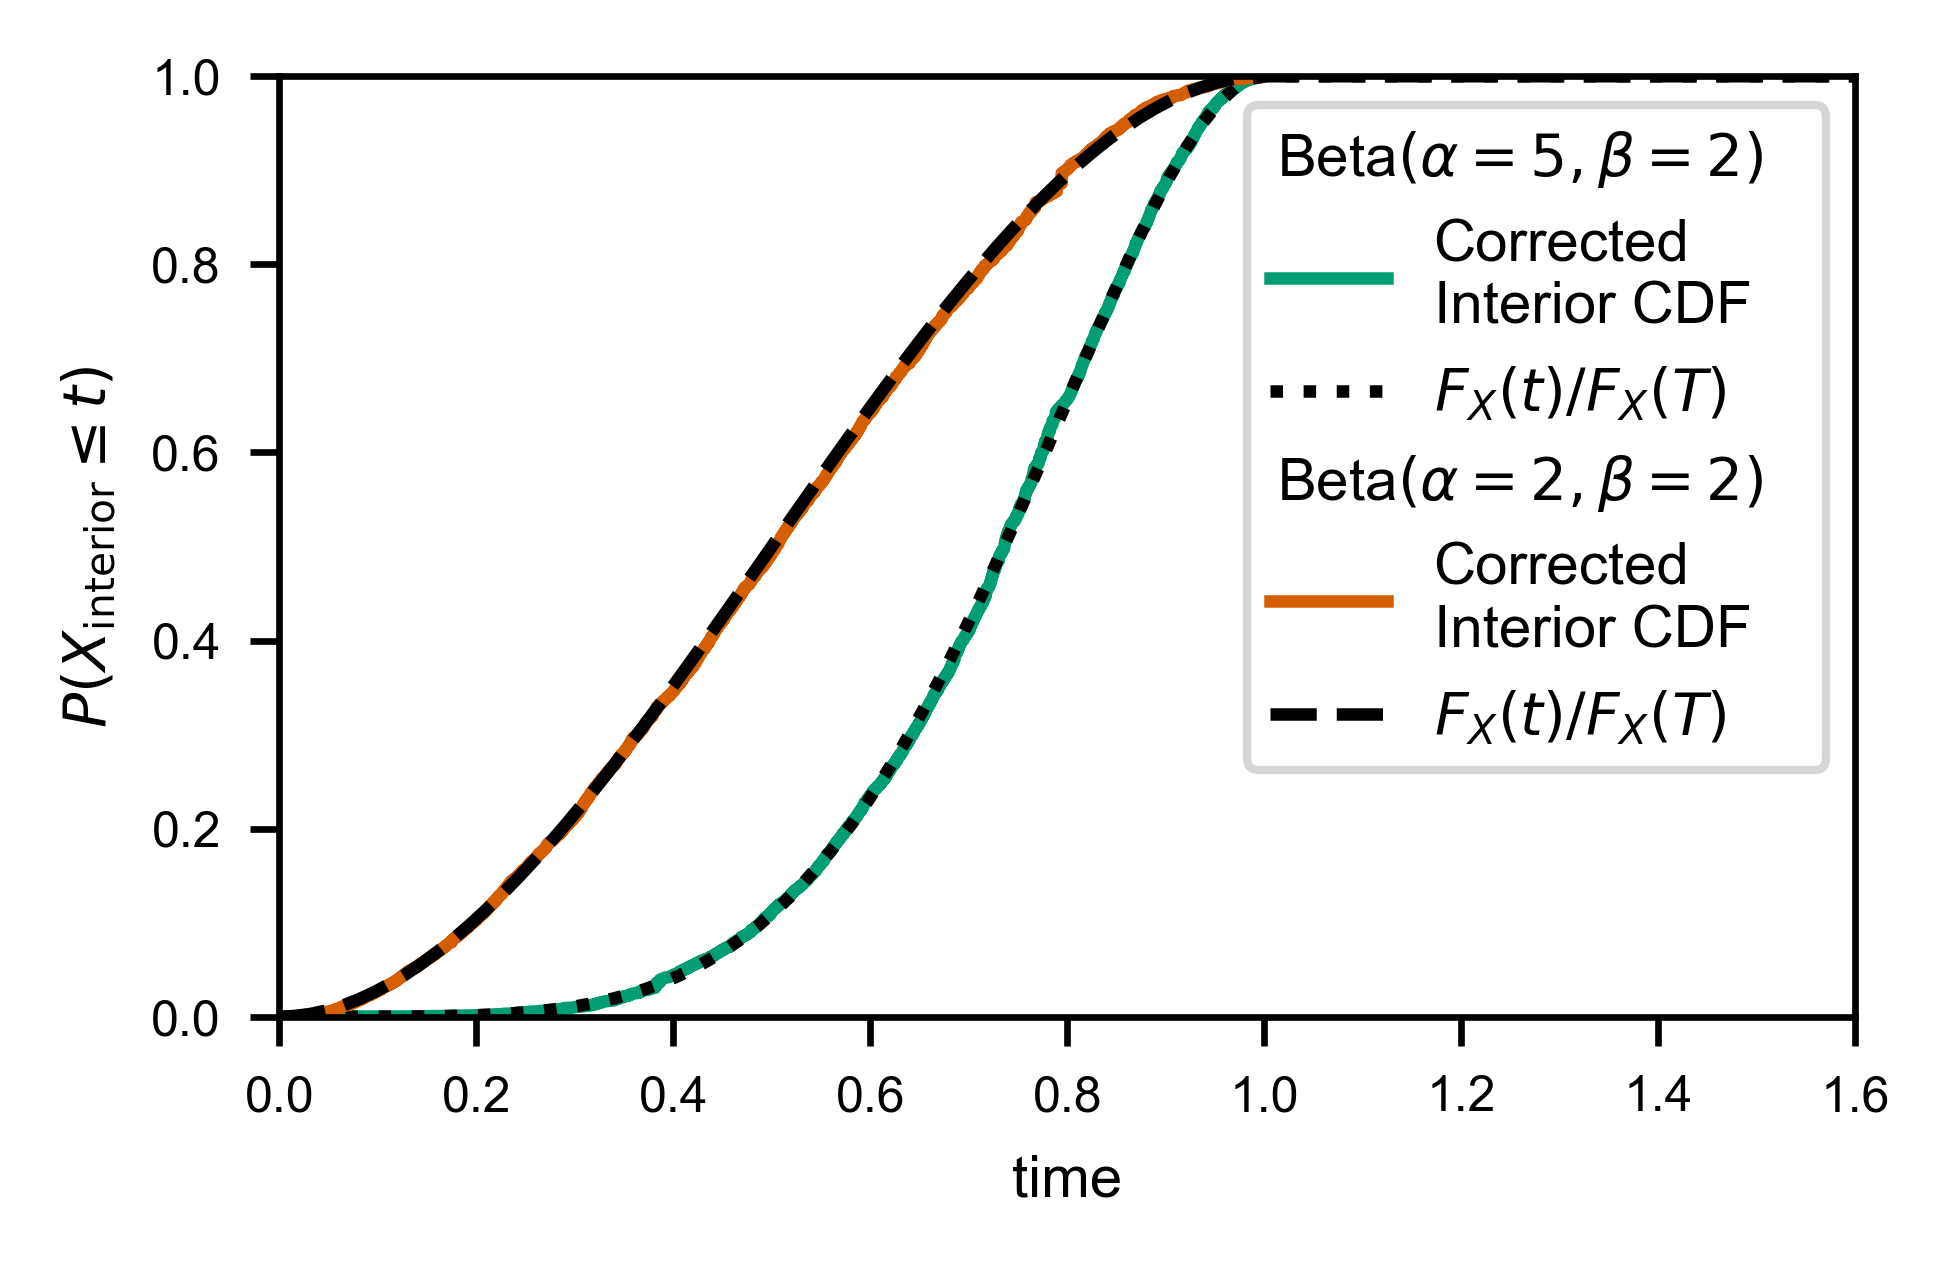

In [759]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in var_pair}
T = multi_T_waits.window_size.max()
window_sizes, window_cumulant = fw.ecdf(
    multi_T_waits.groupby(['window_end', 'replicate'])['window_size'].first().values, 
    pad_left_at_x=0
)
for var in var_pair:
    t = np.linspace(0, T, 100)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
       
    x, cdf, weights = fw.ecdf_windowed(
        interior.wait_time, interior.window_size,
        pad_left_at_x=0, window_cumulant=window_cumulant
    )
    line, = ax.plot(x, cdf, c=var.color, label='Corrected\nInterior CDF')
    legend_entries[var.name].append(line)
    
    line, = ax.plot(t, var.cdf(t)/var.cdf(T), ls=var.linestyle,
                    c='k', label=f'$F_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

    
ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} \leq t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1, loc='lower right')

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for i in [0, 3]:
        hpack = vpack.get_children()[i]
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

### A Caveat for Discrete Movies


While we would ideally have an exact measurement of when transitions between
`A` and `B` states happen, it is more often the case that we have a "movie" of
sorts, where we measure the state of the system at a fixed set of *frames*.

This only provides us with upper and lower bounds for the actual waiting time
that we're trying to observe. For example, consider the trajectory depicted
below.

        A A A A A B B B B B B B A A A A B
        | - - - | - - - | - - - | - - - |  ...
        |                               |
    t = 0s      1s      2s      3s      4s

This trajectory, when measured at the discrete times shown, would look like

```python
pd.Series({0: 'A', 1: 'A', 2: 'B', 3: 'A', 4: 'B'}).head()
    0    A
    1    A
    2    B
    3    A
    4    B
    dtype: object
```

Naively, if you only had this movie in front of you with no knowledge of the
actual underlying state change times, it might seem to suggest that there was an
exterior-censored "A" of length 2, one each interior censored times of length 1,
and one exterior-censored "B" time of length 1. However, by looking at the true
trajctory above, we see that the first "A" wait was much shorter than 2s, and
the first "B" wait was much longer than 1s, whereas the last "A" wait just
happened to match up with our prediction of 1s.

Because our normalization factor depends non-linearly on the observed waiting
time, one might guess that simply using the "naive" times might cause bias. We
will show that this is the case by generating some artificial movies ourselves.

### Generating Discrete Trajectories (Movies)

`multi_locus_analysis.finite_window` includes a convenience method for
generating "movie frames" from the output of the `AB_window*` functions:

In [763]:
print(fw.state_changes_to_movie_frames.__doc__)



    Convert state changes into discrete-time observations of state.

    Takes a Series of state change times into a Series containing
    observations at the times requested. The times become the index.

    Parameters
    ----------
    times : (N,) array_like
        times at which to "measure" what state we're in to make the new
        trajectories.
    traj : pd.DataFrame
        should have `state_col` and `start_times_col` columns. the values of
        `state_col` will be copied over verbatim.
    state_col : string
        name of column containing the state being transitioned out of for each
        measurement in `traj`.
    start_times_col : string
        name of column containing times at which `traj` changed state
    end_times_col : (optional) string
        by default, the function assumes that times after the last start time
        are in the same state. if passed, this column is used to determine at
        what time the last state "finished". times after this wil

This function has an alias for convenience: 
`multi_locus_analysis.finite_window.traj_to_movie`.

In [821]:
T = trajs.window_end.max()
movie_frame_t = np.linspace(0, T, 21)
movies = trajs.groupby('replicate').apply(
    fw.traj_to_movie,
    times=movie_frame_t
)
movies.head()


t,0.00,0.04,0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,...,0.44,0.48,0.52,0.56,0.60,0.64,0.68,0.72,0.76,0.80
replicate,,,,,,,,,,,,,,,,,,,,,
0,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)"
1,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)"
2,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"
3,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)",...,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"
4,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"


We can get a long-form DataFrame by simply doing

In [822]:
movies = movies.T.unstack()
movies.name = 'state' # name resulting column from unstack
movies.head()


replicate  t   
0          0.00    Beta(2, 2)
           0.04    Beta(2, 2)
           0.08    Beta(2, 2)
           0.12    Beta(2, 2)
           0.16    Beta(2, 2)
Name: state, dtype: object

For this type of discrete data, there is a separate function for computing the waiting times DataFrame:

Which also has a convenient alias: `multi_locus_analysis.finite_window.movie_to_waits`:

In [825]:
discrete_waits = pd.DataFrame(movies).reset_index().groupby('replicate').apply(fw.movie_to_waits)
discrete_waits.head()

start_time  end_time  wait_time       state  min_waits  \
replicate rank_order                                                           
0         0                 0.00      0.52       0.52  Beta(2, 2)       0.48   
          1                 0.52      0.80       0.28  Beta(5, 2)       0.28   
1         0                 0.00      0.24       0.24  Beta(5, 2)       0.20   
          1                 0.24      0.64       0.40  Beta(2, 2)       0.36   
          2                 0.64      0.76       0.12  Beta(5, 2)       0.08   

                      max_waits       wait_type  window_size  
replicate rank_order                                          
0         0                0.52   left exterior          0.8  
          1                0.32  right exterior          0.8  
1         0                0.24   left exterior          0.8  
          1                0.44        interior          0.8  
          2                0.16        interior          0.8

As described above, notice the difference between the measured "wait times" from the discrete movie and the "real" wait times from the original trajectories:

In [780]:
waits.head()

state  start_time  end_time  window_start  \
replicate rank_order                                                   
0         0           Beta(5, 2)    0.000000  0.500970             0   
          1           Beta(2, 2)    0.500970  0.800000             0   
1         0           Beta(2, 2)    0.000000  0.213959             0   
          1           Beta(5, 2)    0.213959  0.600257             0   
          2           Beta(2, 2)    0.600257  0.758874             0   

                      window_end  wait_time  window_size       wait_type  
replicate rank_order                                                      
0         0                  0.8   0.500970          0.8   left exterior  
          1                  0.8   0.299030          0.8  right exterior  
1         0                  0.8   0.213959          0.8   left exterior  
          1                  0.8   0.386298          0.8        interior  
          2                  0.8   0.158617          0.8        interior

Looks like it works as well as one could hope....

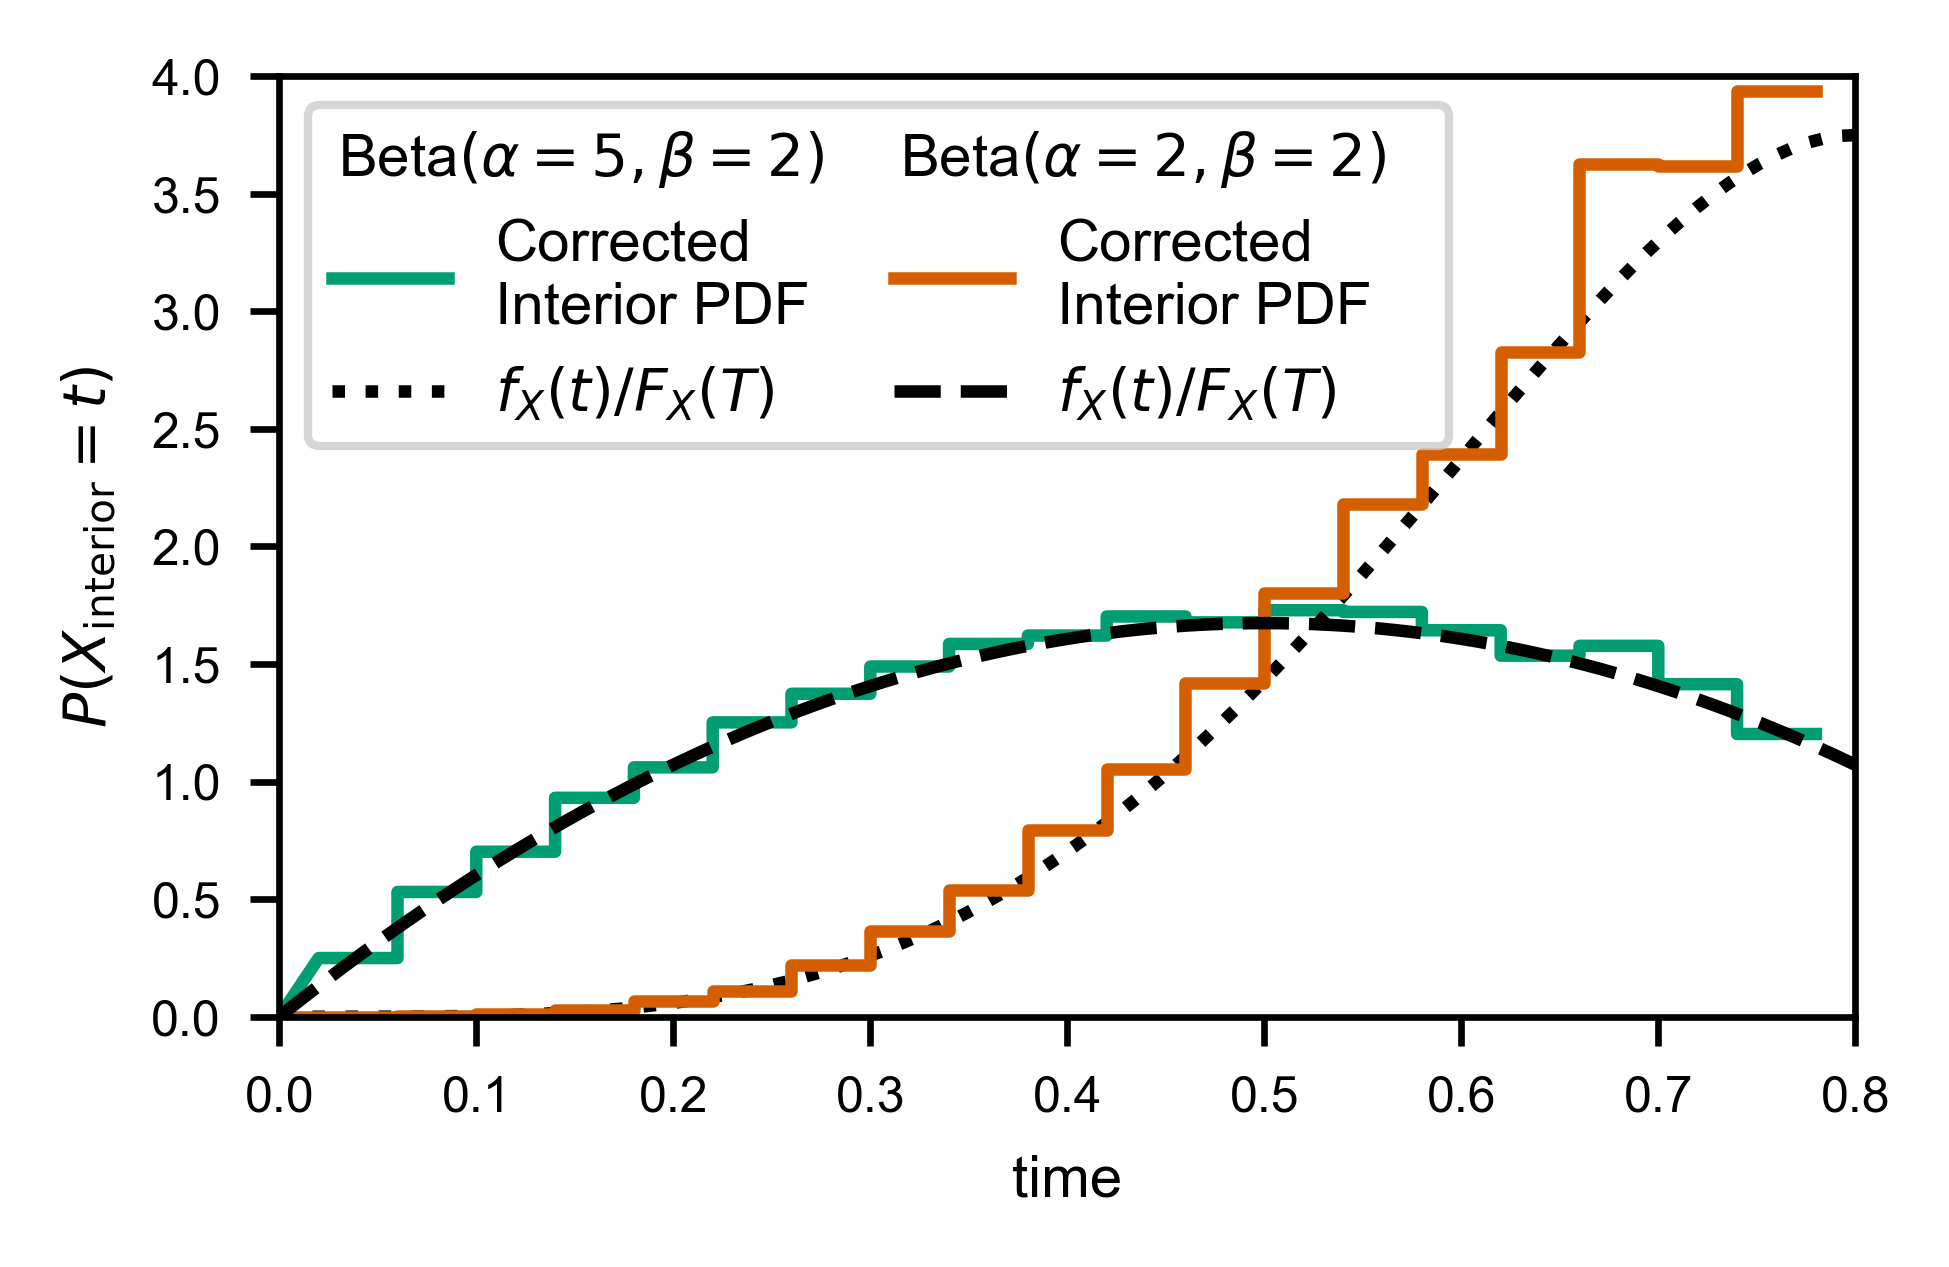

In [833]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in var_pair}
T = discrete_waits.window_size.max()
for var in var_pair:
    interior = discrete_waits.loc[
        (discrete_waits['state'] == var.name) & (discrete_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ]

    # don't need to bin to create histogram, since we measure only a discrete set of times
    x, cdf = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        times_allowed=movie_frame_t
    )
    # deals with empty final bin, shifting bins over by half a dt, prepending the zero, etc.
    X, Y = stats.bars_given_discrete_cdf(x, cdf)
    line, = ax.plot(X, Y, c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

    t = np.linspace(0, T, 100)
    line, = ax.plot(t, var.pdf(t)/var.cdf(T), 
                    c='k', ls=var.linestyle, label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 4])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

## Theoretical Details


The following section contains a complete derivation of the framework used to
generate the corrections used in this module.

### Motivating (A)synchronicity

We first motivate our definition of "(a)synchronicity", the critical property
that allows us to correct for the effects of observing in a finite window.

Suppose a process starts at :math:`-t_\text{inf}` (WLOG, assume it starts in
state :math:`A`). For times after :math:`-t_\text{inf} \lll 0`, the process switches
between states :math:`A` and :math:`B`. The distribution of times spent in each
state before switching are IID, and distributed like :math:`f_A(t)` and
:math:`f_B(t)`, respectively. We then are able to observe the process during the
interval of time :math:`[0, T]`.

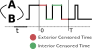

In [86]:
from IPython.core.display import SVG
SVG(filename='./images/waiting-time-base-diagram.svg')

This can be thought of as a renewal(-reward) process that started far in the
past. As long as the starting point, :math:`-t_\text{inf}`, is sufficiently far
in the past, and the distributions :math:`f_*(t)` have finite variance, various
convenient properties hold true for the observed state switching times between
:math:`0` and :math:`T`. We use the same example as in the "tutorial" section in
what follows.

In [ ]:
import scipy.stats
from multi_locus_analysis import finite_window as fw
e44 = scipy.stats.expon(scale=4, loc=4)
e16 = scipy.stats.expon(scale=6, loc=1)
trajs = fw.ab_window([e44.rvs, e16.rvs], window_size=20, offset=-1000,
    num_replicates=10000, states=['exp(4,4)', 'exp(1,6)'])

The first convenient property is that the switching times are uniformly
distributed within the observation interval (as
:math:`-t_\text{inf}\to-\infty`). Intuitively, this just means that
:math:`-t_\text{inf}` is far enough in the past that, independently of the
distribution, we are not biased towards the switching times being early or late
in our observation interval (i.e. we have lost all memory of the "real" start
time).

In [ ]:
plt.figure(figsize=[4,3])
plt.hist(trajs['start_time'].values, 100)
plt.xlim([0, 20])
plt.xlabel('Rate of "creation of left ends"')

Now let's label the observed state switches as :math:`t_0,\ldots{},t_{n-1}`,
with :math:`t_0` and :math:`t_n` corresponding to the "actual" (unobserved)
state switch times flanking the observation interval.
The next useful property is that the start of the observation interval
(:math:`t=0`) is uniformly distributed within :math:`[t_0, t_1]` (similarly, the
end of the observation interval, :math:`t=T`, is uniformly distributed in
:math:`[t_{n-1}, t_n]`.

In [ ]:
plt.figure(figsize=[4,3])
t01 = trajs[trajs['start_time'] < 0]
u = -t01['start_time']/(t01['end_time'] - t01['start_time'])
plt.hist(u, 100)
plt.xlabel('Fraction of way between state changes at $t=0$.')

For the interior times, we can simply use the first fact to derive our interior
time correction. Since we know the starting times of each state are uniformly
distributed, we immediately can tell that if a waiting time of length
$\tau$ has a start time within the interval, then the the fraction of
times that this waiting time will end up being an interior time is just
$(T - \tau)/T$. More precisely, we have that

$$
    P(t_{i+1} \leq T | t_{i+1}-t_i=\tau, t_i \in [0,T]) = \int_0^T 1_{t_i + \tau
    \leq T} f_{\text{Unif}[0,T]}(t_i) dt_i
$$

which is just equal to :math:`(T - \tau)/T`.

This correction factor can be visualized easily as simply counting what fraction
of "start" times of a given length lead to "end" times still inside the
interval. Namely, it's the green part of the interval in the following diagram:

.. image:: images/waiting-time-censored-fraction.svg

    :width: 400
    
    :alt: pictoral demonstration of equation above

On the other hand, we have to be careful about the distribution of exterior
times, even if we do somehow magically have the values
of :math:`t_0` and the state at :math:`t=0`. You can't simply assume that
:math:`t_1 - t_0` is distributed like :math:`f_A(t)` or :math:`f_B(t)`. After
all, in fact it is distributed like :math:`tf_*(t)`. This is because (loosely
speaking) if you fill the real line with a bunch of intervals whose lengths are
distributed like :math:`f(t)`, then you choose a point on the real line at
random, you are more likely to land in an interval of size :math:`t` the longer
that :math:`t` is.

In [ ]:
plt.figure(figsize=[4,3])
a1 = t01[t01['state'] == 'exp(4,4)']
x, cdf = fw.ecdf(a1['end_time'] - a1['start_time'])
kernel = fw.smooth_pdf(x, cdf)
plt.plot(x, kernel(x), label=r'$\hat{f}(t)$: Observed CDF of $t_1 - t_0$')
plt.plot(x, e44.pdf(x), label=r'$f(t)$: Actual CDF of exp(4,4)')
Z = scipy.integrate.quad(lambda x: x*e44.pdf(x), 0, np.inf)
plt.plot(x, x*e44.pdf(x)/Z[0], label=r'$t f(t)/\int_0^\infty t f(t) dt$')
plt.legend()

### (A)synchronicity

While the explicit framework presented above is a useful tool, it is ill-defined
for heavy-tailed processes, in which we are primarily concerned when making
these types of corrections. In order to retain the useful properties of the
system that made it possible to derive the interior and exterior times
distributions, we simply notice that the *real* property that we want to be true
when measuring these systems is *asynchronicity*, or what a physicist might call
"symmetry under time translations" or "time homogeneity". In short, we want to
impose the constraint that we are only interested in scientific measurements
where changing the interval of observation :math:`[0, T]` to
:math:`[0+\tau,T+\tau]` for any :math:`\tau` will not change any properties of
the measurement.

<div class="alert alert-info">

    We leave as an exercise to the reader to show that:

    1. the renewal process of the previous section is a special case of an asynchronous process
    2. this definition of asynchronicity produces all three properties we demonstrated for our renewal process above
   
</div>

On the other extreme from asynchronicity is the situation in which the
Meier-Kaplan correction was originally designed to be used. Namely, we could
imagine that a perfectly *synchronous* process is one where :math:`t_0` is fixed
to be at time :math:`t=0`, meaning that :math:`t_1 - t_0` is distributed as just
:math:`f_*(t)`.

While in principle anything between asynchrony and synchrony is possible, it is
true in general that almost all scientific measurements area already done using
either purely synchronous or asynchronous systems, since it is intuitively clear
that a lack of understanding of the synchronicity of one's system can lead to
uninterpretable results.

### Laplace Formalism


TODO: fill in alternative formulation of system here.

In [20]:
from multi_locus_analysis import stats

import lifelines
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns

import bruno_util.plotting as bplt
figure_size = bplt.use_cell_style(mpl.rcParams)

km_color = sns.color_palette('colorblind')[0]
interior_color = sns.color_palette('colorblind')[1]
interior_linestyle = '-.'


def compare_interior_kaplan(waits, var_pair, rescale_kaplan=False,
                            rescale_interior=False):
    """
    Interior vs kaplan est for `multi_locus_analysis.finite_window.ab_window`.

    Compare the Kaplan-Meier estimator to the empirical distribution function
    (eCDF) of interior times of data generated using the
    `multi_locus_analysis.finite_window.ab_window` or
    `multi_locus_analysis.finite_window.ab_window_fast` functions.
    """
    kmfs = {}
    for name, state in waits.groupby('state'):
        times = state['wait_time'].values
        not_censored = (state['wait_type'] == 'interior').values
        kmfs[name] = lifelines.KaplanMeierFitter().fit(
            times, event_observed=not_censored,
            label=r'Meier-Kaplan Estimator, $\pm$95% conf int'
        )

    fig = plt.figure(
        figsize=figure_size['two-by-half column, four legend entries above'],
        constrained_layout=True
    )
    axs = fig.subplot_mosaic([[var.name for var in var_pair]])

    T = waits.window_size.max()
    for var in var_pair:
        # lifelines insists on returning a new Axes object....so we have to
        # plot it first
#         ax = kmfs[var.name].plot_cumulative_density(
#             color=km_color, ax=axs[var.name]
#         )
#         km_l = mpl.lines.Line2D([], [], color=km_color, label='Kaplan-Meier')

        ax = axs[var.name]
    
        tk = kmfs['Beta(2, 2)'].cumulative_density_.index.values
        kmf = kmfs['Beta(2, 2)'].cumulative_density_.values
        Z = 1
        Z = kmf[-1] / var.cdf(T)
        km_l = ax.plot(tk, kmf/Z, color=km_color, label='Kaplan-Meier')

        # plot actual distribution
        t = np.linspace(0, T, 100)
        analytical_l,  = ax.plot(
            t, var.cdf(t), color='k', label='Actual CDF'
        )

        # now compute the empirical distribution of the "interior" times
        interior = waits.loc[
            (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
            'wait_time'
        ].values
        x, cdf = fw.ecdf(interior, pad_left_at_x=0)

        interior_l, = ax.plot(
            x, cdf*var.cdf(x[-1]), c=var.color, ls=interior_linestyle,
            label='"Interior" eCDF'
        )

        # prettify the plot
        ax.set_xlim([0, waits.window_size.max()])
        ax.set_ylim([0, 1])
        ax.set_xlabel('time')
        ax.set_ylabel(r'Cumulative probability')

        ax.legend(
            title=var.pretty_name,
            handles=[interior_l, km_l, analytical_l],
            # align bottom of legend 2% ax height above axis, filling full axis
            # width
            bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncol=1, mode="expand", borderaxespad=0.
        )
    return fig



In [10]:
waits = observations['beta']

In [11]:
var_pair = variable_pairs['beta']

In [18]:
tk = kmfs['Beta(2, 2)'].cumulative_density_.index.values
kmf = kmfs['Beta(2, 2)'].cumulative_density_.values

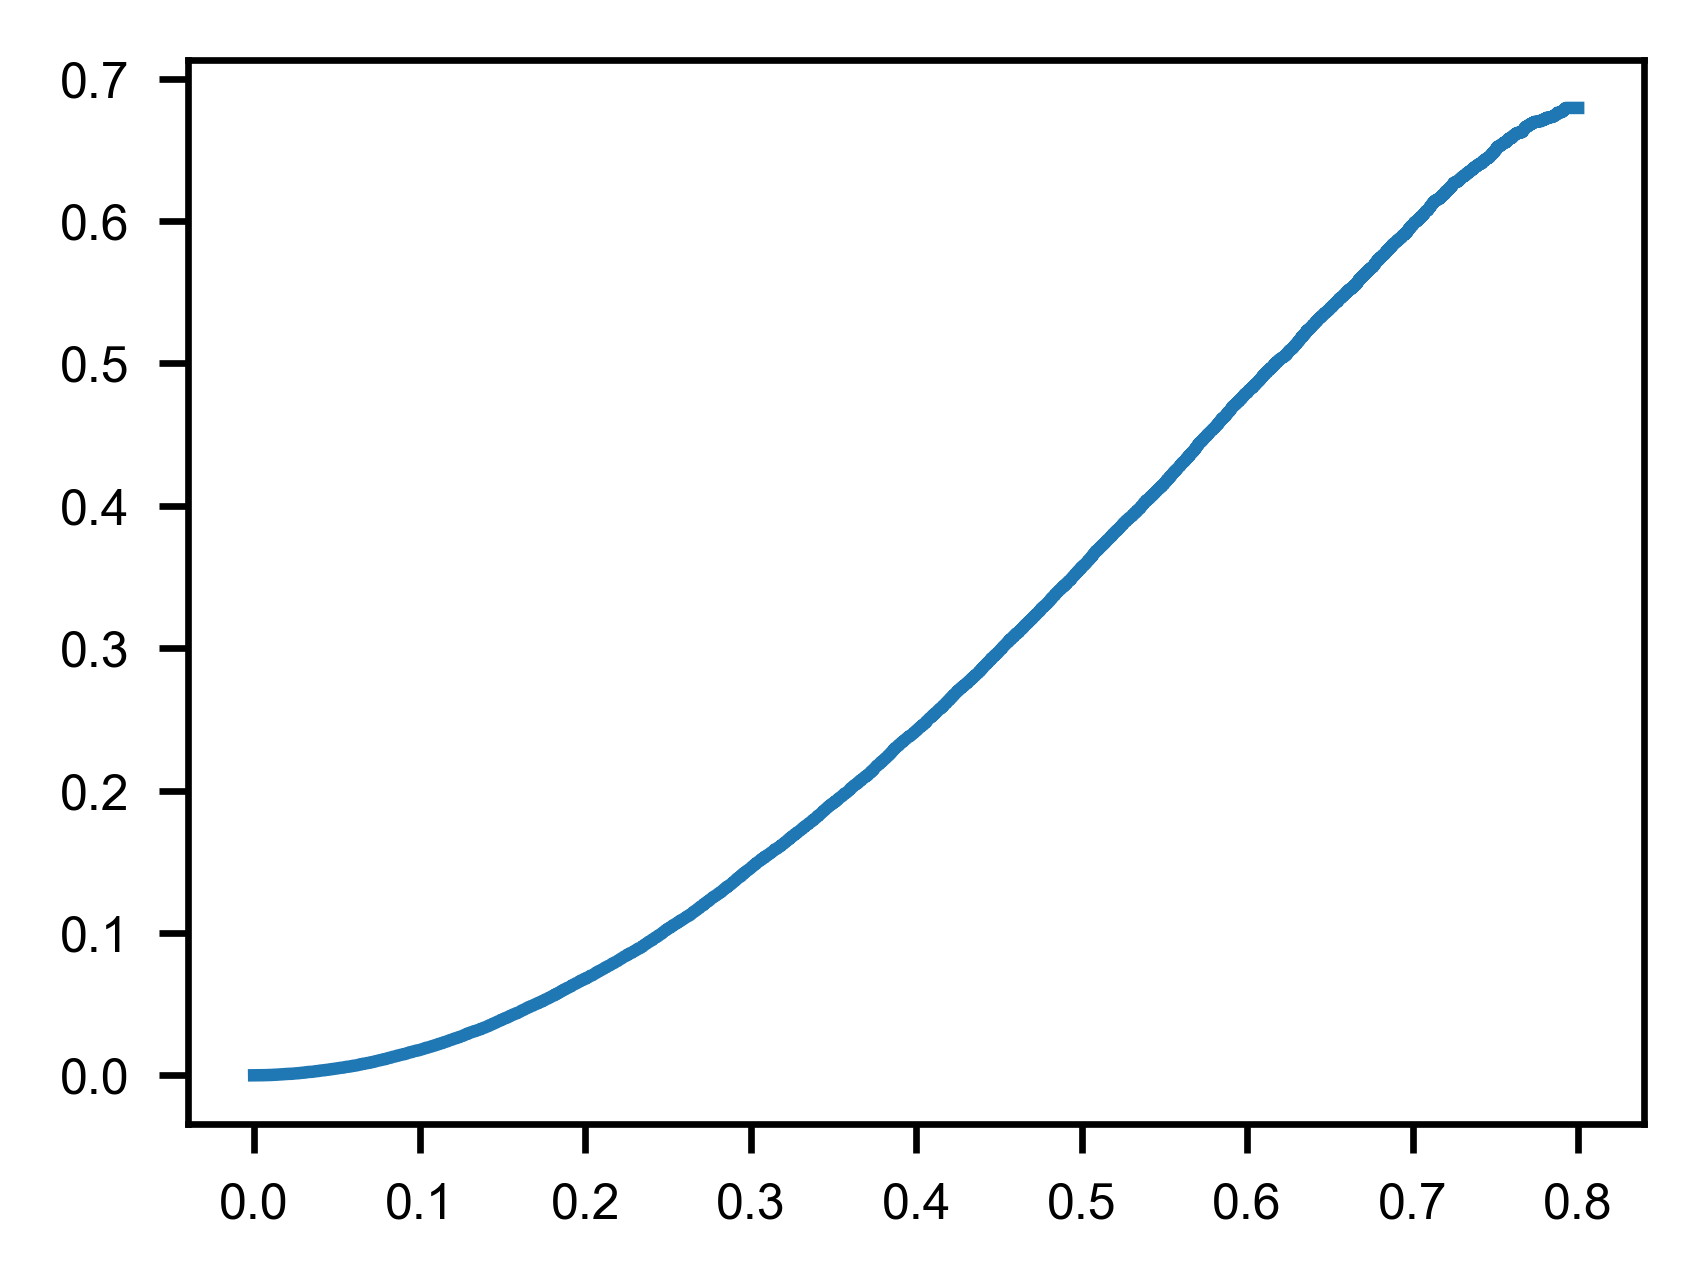

In [19]:
plt.plot(tk, kmf/kmf[-1]*)

In [29]:
low, high = kmfs['Beta(2, 2)'].confidence_interval_cumulative_density_.values.T

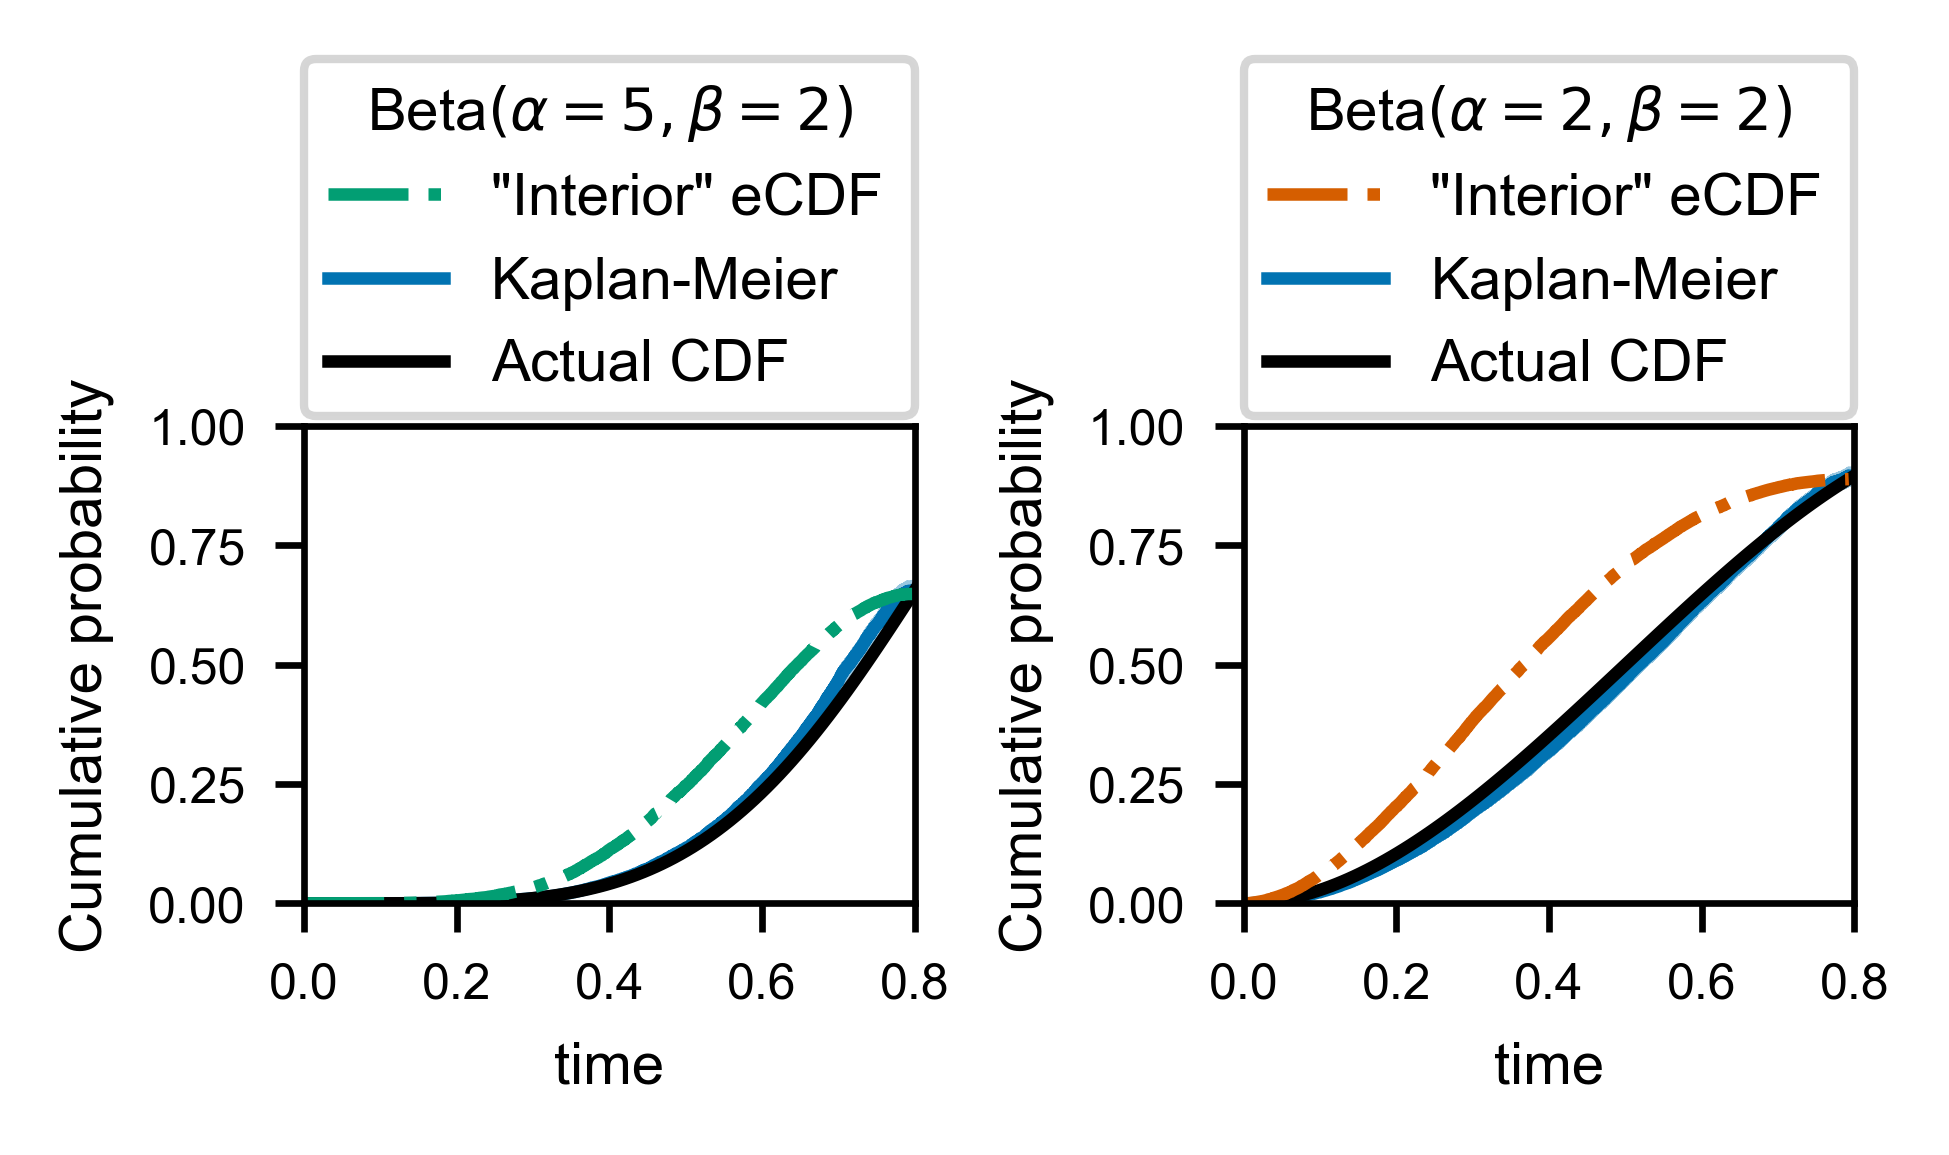

In [32]:
kmfs = {}
for name, state in waits.groupby('state'):
    times = state['wait_time'].values
    not_censored = (state['wait_type'] == 'interior').values
    kmfs[name] = lifelines.KaplanMeierFitter().fit(
        times, event_observed=not_censored,
        label=r'Meier-Kaplan Estimator, $\pm$95% conf int'
    )

fig = plt.figure(
    figsize=figure_size['two-by-half column, four legend entries above'],
    constrained_layout=True
)
axs = fig.subplot_mosaic([[var.name for var in var_pair]])

T = waits.window_size.max()
for var in var_pair:
    # lifelines insists on returning a new Axes object....so we have to
        # plot it first
#         ax = kmfs[var.name].plot_cumulative_density(
#             color=km_color, ax=axs[var.name]
#         )
#         km_l = mpl.lines.Line2D([], [], color=km_color, label='Kaplan-Meier')

    ax = axs[var.name]

    tk = kmfs[var.name].cumulative_density_.index.values
    kmf = kmfs[var.name].cumulative_density_.values
    Z = 1
    Z = kmf[-1] / var.cdf(T)
    km_l = ax.plot(tk, kmf/Z, color=km_color, label='Kaplan-Meier')[0]
    low, high = kmfs[var.name].confidence_interval_cumulative_density_.values.T
    ax.fill_between(tk, low/Z, high/Z, color=km_color, alpha=0.4)
    # plot actual distribution
    t = np.linspace(0, T, 100)
    analytical_l,  = ax.plot(
        t, var.cdf(t), color='k', label='Actual CDF'
    )

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)

    interior_l, = ax.plot(
        x, cdf*var.cdf(x[-1]), c=var.color, ls=interior_linestyle,
        label='"Interior" eCDF'
    )

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'Cumulative probability')

    ax.legend(
        title=var.pretty_name,
        handles=[interior_l, km_l, analytical_l],
        # align bottom of legend 2% ax height above axis, filling full axis
        # width
        bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        ncol=1, mode="expand", borderaxespad=0.
    )